# Analysis of NO2 emission from shipping

## Import modules

In [147]:
## Modules for data loading
import os
import copy
import netCDF4 as nc
import pandas as pd
import datetime

## Modules for statistical analysis & wrangling
import numpy as np
from scipy import stats
import astropy.convolution.convolve as convolve
from scipy.signal import convolve2d
import spreg
import statsmodels.tsa.seasonal
import pymannkendall as mk

## Modules for clustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from kneed import KneeLocator

## Modules for mapping & plotting
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.io.shapereader
from shapely import geometry
from shapely.ops import unary_union
from shapely.prepared import prep
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## Define functions

In [148]:
# Gauss circle function
def gauss_circle(r=5):
    arr = np.zeros((2 * r + 1, 2 * r + 1), dtype=int)
    for row in range(arr.shape[0]):
        for col in range(arr.shape[1]):
            if np.sqrt(np.square(row - r) + np.square(col - r)) <= r:
                arr[row, col] = 1
    return(arr)

# ConvGistar function
def ConvGistar(input_array, kernel=gauss_circle()):
    ConvGistar = np.empty(input_array.shape)
    Xbar = np.nanmean(input_array, axis=(1, 2))
    n = input_array.shape[1]*input_array.shape[2]
    for i in range(input_array.shape[0]):
        ConvGistar[i] = (convolve(input_array[i], kernel, boundary='fill', fill_value=np.nan, preserve_nan=True, normalize_kernel=False) - Xbar[i]*np.nansum(kernel)) / (np.sqrt(convolve(np.square(input_array[i]), kernel, boundary='fill', fill_value=np.nan, preserve_nan=True, normalize_kernel=False) - np.square(Xbar[i])) * np.sqrt((n*np.nansum(np.square(kernel)) - np.square(np.nansum(kernel))) / (n - 1)))
    ConvGistar[np.isnan(input_array) == True] = np.nan
    return ConvGistar

# is_land function
def is_land(land, lon, lat):
    return land.contains(geometry.Point(lon, lat))

## Load dataset

Load TROPOMI dataset: NO<sub>2</sub> VCD

In [149]:
## Load TROPOMI dataset (netCDF)
no2_nc_filename = "./dataset/cube_no2_shipping_Jizan.nc"

## Read netCDF file
ds = nc.Dataset(no2_nc_filename, 'r')

## Store dimension information (time, latitude, and longitude)
dim_names = list(ds.dimensions) # get variable keys
time, lats, lons = ds.variables[dim_names[0]][:], ds.variables[dim_names[1]][:], ds.variables[dim_names[2]][:]
print("Dimensions of netCDF NO2 data:")
for dim in ds.dimensions.items():
    print(dim)

## Store NO2 column measurements from netCDF dataset
product = ds['/PRODUCT']
no2_vcd_attr = list(product.variables.items())
no2_vcd_name = no2_vcd_attr[0][0]
no2_vcd = product.variables[no2_vcd_name][:len(time)] # vertical column

## Close netCDF file
ds.close()

## Crop the dataset and dimension w.r.t. the region of interest
## If interested in a smaller ROI, change lats_roi = (0, lats_roi), and lons_roi = (0, lons_roi) where lats_roi <= lats.size and lons_roi <= lons.size
lats_roi = (0, lats.size)
lons_roi = (0, lons.size)
lats, lons = lats[lats_roi[0]:lats_roi[1]], lons[lons_roi[0]:lons_roi[1]]
no2_vcd = no2_vcd[:, lats_roi[0]:lats_roi[1], lons_roi[0]:lons_roi[1]]
extent = [min(lons), max(lons), min(lats), max(lats)] # coordinate extent of given netCDF dataset

## only run when Indian Ocean
# no2_scd[330, :, 160:] = np.nan ## Part of Indian Ocean dataset on 29 October 2019 should be masked due to large noise

del dim_names, dim, ds, product, no2_vcd_attr, no2_vcd_name

Dimensions of netCDF NO2 data:
('Time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Time', size = 1072)
('Latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'Latitude', size = 320)
('Longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'Longitude', size = 320)


Load shipping frequency dataset

In [150]:
## Load shipping frequency dataset (npy)
ship_freq_npy_filename = "./dataset/ship_freq_Jizan.npy" # Using ship track count data from Halpern, B. et al. (2015), regridded on the same WGS84 coordinate
ship_freq = np.load(ship_freq_npy_filename)[::-1, :][lats_roi[0]:lats_roi[1], lons_roi[0]:lons_roi[1]]
ship_freq = ship_freq/np.nanmax(ship_freq) # normalization; range of ship track data: [0, max. of ship_freq)

del ship_freq_npy_filename

Filter out the land coordinates from NO<sub>2</sub> VCD

In [151]:
# Build ocean_mask
x, y = np.array(lons), np.array(lats)
xx, yy = np.meshgrid(x, y, sparse = True)
ocean_mask = np.empty([len(lats), len(lons)])
land = prep(unary_union(list(cartopy.io.shapereader.Reader(cartopy.io.shapereader.natural_earth(resolution='10m', category='physical', name='land')).geometries())))
for i in range(len(lons)):
    for j in range(len(lats)):
        ocean_mask[j, i] = not is_land(land, x[i], y[j])

# Replace land coordinate with NaN
ocean_mask[ocean_mask==0] = np.nan
print("Check on ocean_mask with NaN (1. if ocean, np.nan if land):\n", ocean_mask)
no2_vcd = np.multiply(np.array(copy.deepcopy(no2_vcd)[:, :, :].data), ocean_mask)

Check on ocean_mask with NaN (1. if ocean, np.nan if land):
 [[ 1.  1.  1. ... nan nan nan]
 [ 1.  1.  1. ... nan nan nan]
 [ 1.  1.  1. ... nan nan nan]
 ...
 [nan nan nan ...  1.  1.  1.]
 [nan nan nan ...  1.  1.  1.]
 [nan nan nan ...  1.  1.  1.]]


## Plot map

Adjust plotting parameters

In [152]:
## Customize parameters for plotting
## Parameters for publication (high resolution)
plt.style.use('ggplot')
plt.rcParams['font.size'] = 13.5
plt.rcParams['xtick.labelsize'], plt.rcParams['ytick.labelsize'] = 13.5, 13.5
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
fig_size = [abs(extent[1] - extent[0]), abs(extent[3] - extent[2])]

Plot base map

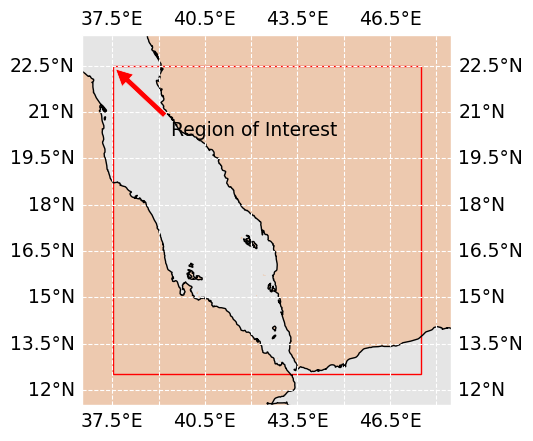

In [153]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')
ax.set_extent([extent[0] - 1, extent[1] + 1, extent[2] - 1, extent[3] + 1])

## Add a rectangle patch and an annotation
ax.add_patch(matplotlib.patches.Rectangle((extent[0], extent[2]), fig_size[0], fig_size[1], linewidth=1, edgecolor='r', facecolor='none'))
ax.annotate('Region of Interest', xy=(extent[0], extent[3]), xytext=(extent[0]*1.05, extent[3]*0.90),
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

Plot ocean coordinates only

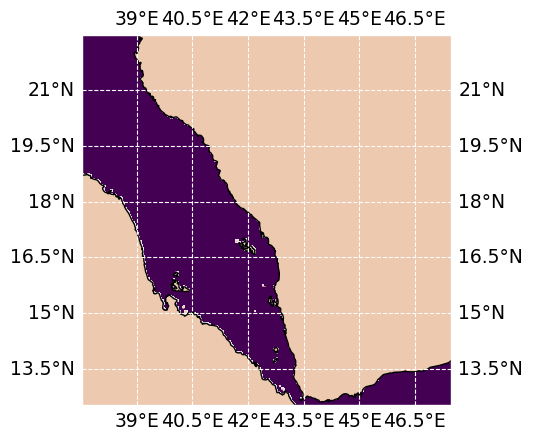

In [154]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot ocean-coordinates only
plt.imshow(ocean_mask, extent=[extent[0], extent[1], extent[2], extent[3]], cmap='viridis')
plt.show()

Plot true shipping frequency

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\4075619267.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(matplotlib.cm.ScalarMappable(cmap='viridis'),


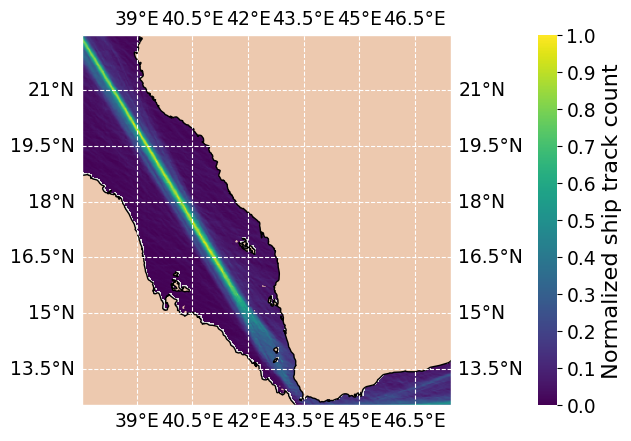

In [155]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot true shipping frequency
plt.imshow(ship_freq, extent=[extent[0], extent[1], extent[2], extent[3]], cmap='viridis')
plt.colorbar(matplotlib.cm.ScalarMappable(cmap='viridis'),
             fraction=0.0426, pad = 0.175, extend='neither', ax=plt.gca(),
             ticks=np.linspace(np.floor(np.nanmin(ship_freq) * 100) / 100, np.ceil(np.nanmax(ship_freq) * 100) / 100, 11),
             label='Normalized ship track count').outline.set_edgecolor(None)
plt.show()

Plot daily measurement data

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\454657567.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cmap='viridis', fraction=0.0426, pad=0.175, extend='both',


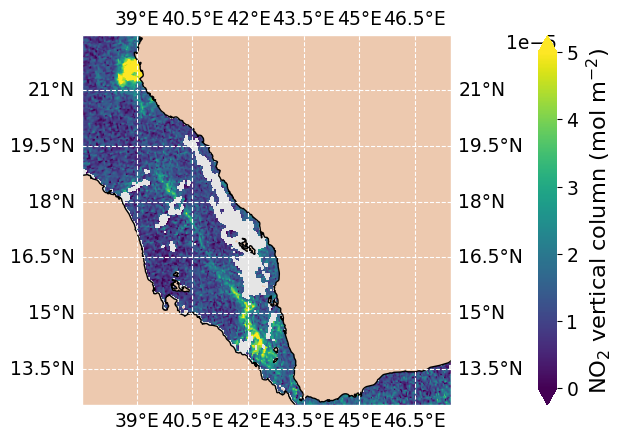

In [156]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot daily measurement data
plt.imshow(copy.deepcopy(no2_vcd)[888, :, :], # May 11th 2021
           cmap='viridis', extent=[extent[0], extent[1], extent[2], extent[3]], vmin=0, vmax=0.00005)
plt.colorbar(cmap='viridis', fraction=0.0426, pad=0.175, extend='both',
             label='NO$_{2}$ vertical column (mol m$^{-2}$)').outline.set_edgecolor(None)
plt.show()

Plot average measurement data over entire period

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\4248131656.py:8: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(copy.deepcopy(no2_vcd)[:, :, :], axis = 0),
C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\4248131656.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cmap='viridis', fraction=0.0426, pad=0.175, extend='both',


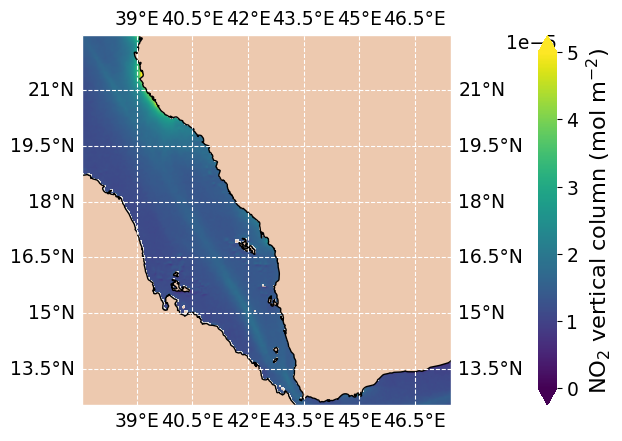

In [157]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot average measurement data over entire period
plt.imshow(np.nanmean(copy.deepcopy(no2_vcd)[:, :, :], axis = 0),
           cmap='viridis', extent=[extent[0], extent[1], extent[2], extent[3]], vmin=0, vmax=0.00005)
plt.colorbar(cmap='viridis', fraction=0.0426, pad=0.175, extend='both',
             label='NO$_{2}$ vertical column (mol m$^{-2}$)').outline.set_edgecolor(None)
plt.show()

Perform statistical analysis

In [158]:
## Prepare data
NO2 = np.nanmean(copy.deepcopy(no2_vcd)[:, :, :], axis=0).reshape(-1, 1)
SHIP_TRACK = copy.deepcopy(ship_freq).reshape(-1, 1)
mask = ~np.isnan(NO2) & ~np.isnan(SHIP_TRACK)
X = NO2[mask].reshape(-1, 1)
y = SHIP_TRACK[mask]

## Pearson correlation
print('Spatial correlation between NO2 column level & ship track counts:', stats.pearsonr(NO2[mask], SHIP_TRACK[mask]))

# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y,
    # Independent variables
    X,
    # Dependent variable name
    name_y='Ship track', 
    # Independent variable name
    name_x=['Original NO2']
)
print(m1.summary)

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\3377775121.py:2: RuntimeWarning: Mean of empty slice
  NO2 = np.nanmean(copy.deepcopy(no2_vcd)[:, :, :], axis=0).reshape(-1, 1)


Spatial correlation between NO2 column level & ship track counts: PearsonRResult(statistic=0.15066735347286697, pvalue=6.629861495550228e-138)
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  Ship track                Number of Observations:       27214
Mean dependent var  :      0.1241                Number of Variables   :           2
S.D. dependent var  :      0.1704                Degrees of Freedom    :       27212
R-squared           :      0.0227
Adjusted R-squared  :      0.0227
Sum squared residual:     772.177                F-statistic           :    632.0787
Sigma-square        :       0.028                Prob(F-statistic)     :   6.63e-138
S.E. of regression  :       0.168                Log likelihood        :    9856.864
Sigma-square ML     :       0.028                Akaike info criterion :  -19709.729
S.E of regression ML

Plot scatter plot of original NO2 data

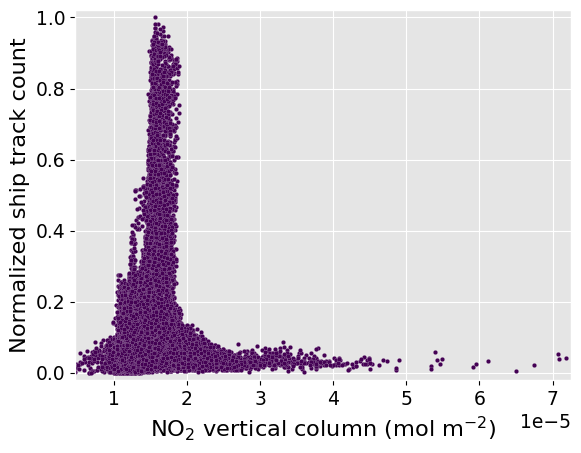

In [159]:
## Scatter plot of NO2 data
fig_boxplot = sns.scatterplot(x=NO2[mask], y=SHIP_TRACK[mask], alpha=1, color='#440154', linewidth=0.1, s=10)
min_before_outlier_removal, max_before_outlier_removal = np.nanmin(NO2[mask]), np.nanmax(NO2[mask])
fig_boxplot.set(xlabel='NO$_2$ vertical column (mol m$^{-2}$)',
                ylabel='Normalized ship track count',
                ylim = (-0.02, 1.02),
                xlim = (0.99 * min_before_outlier_removal, 1.01 * max_before_outlier_removal))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.show()

## Perform clustering NO<sub>2</sub> without spatial data preprocessing

Perform clustering

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1867576579.py:2: RuntimeWarning: Mean of empty slice
  clustered_no2_vcd = np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[:, :, :], ocean_mask), axis=0)
c:\Users\kimsa\OneDrive - g.skku.edu\1_Research\1_NO2\1_Analysis\Code\no2clu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kimsa\OneDrive - g.skku.edu\1_Research\1_NO2\1_Analysis\Code\no2clu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kimsa\OneDrive - g.skku.edu\1_Research\1_NO2\1_Analysis\Code\no2clu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

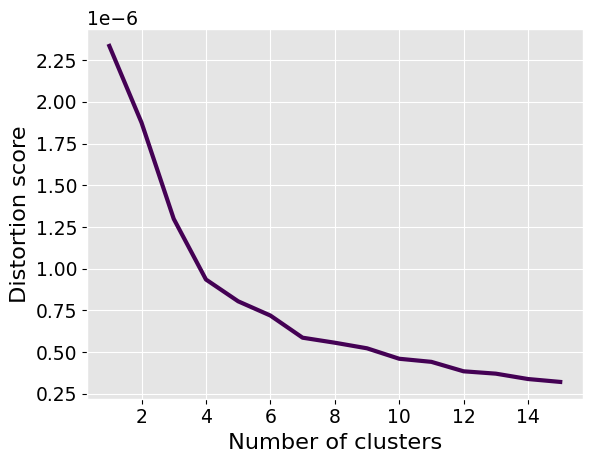

Optimal number of clusters:  4


c:\Users\kimsa\OneDrive - g.skku.edu\1_Research\1_NO2\1_Analysis\Code\no2clu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-means label of NO2:
 [[ 2.  2.  2. ... nan nan nan]
 [ 2.  2.  2. ... nan nan nan]
 [ 2.  2.  2. ... nan nan nan]
 ...
 [nan nan nan ...  2.  2.  2.]
 [nan nan nan ...  1.  1.  1.]
 [nan nan nan ...  1.  1.  1.]]


In [160]:
## Cluster NO2 data (average over entire period)
clustered_no2_vcd = np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[:, :, :], ocean_mask), axis=0)
X = clustered_no2_vcd[~np.isnan(clustered_no2_vcd)].reshape(-1, 1)

## Calculate distortions per k
distortions = []
K = range(1, 16) # grid search of k from 1 to 15
for k in K:
    kmeanModel = KMeans(init='k-means++', n_clusters=k, random_state=1).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
plt.plot(K, distortions, linewidth=3, color='#440154')
plt.grid(True)
plt.xlabel('Number of clusters', color='black')
plt.ylabel('Distortion score', color='black')
plt.show()

## Find the optimal number of clusters
kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
optimal_k = kn.knee
print("Optimal number of clusters: ", optimal_k)

## Run k-means clustering with optimal number of clusters
kmeans1 = KMeans(init='k-means++', n_clusters=optimal_k, random_state=1).fit(X)
idx = np.argsort(kmeans1.cluster_centers_.sum(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(optimal_k)
kmeans1_lab = lut[kmeans1.labels_] + 1
temp_1 = np.zeros([len(lats), len(lons)], dtype=int)
ocean_idx = np.where(ocean_mask.flatten() == 1)
# land_idx = np.where(ocean_mask.flatten() != 1)
np.put(temp_1, ocean_idx, kmeans1_lab)
no2_kmeans_label = np.multiply(temp_1, ocean_mask)
print("K-means label of NO2:\n", no2_kmeans_label)

del clustered_no2_vcd, X, K, k, kn, kmeans1, idx, lut, kmeans1_lab, temp_1

Plot clustered data

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\3658882526.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(fraction=0.0426, pad=0.175, label='Cluster label')


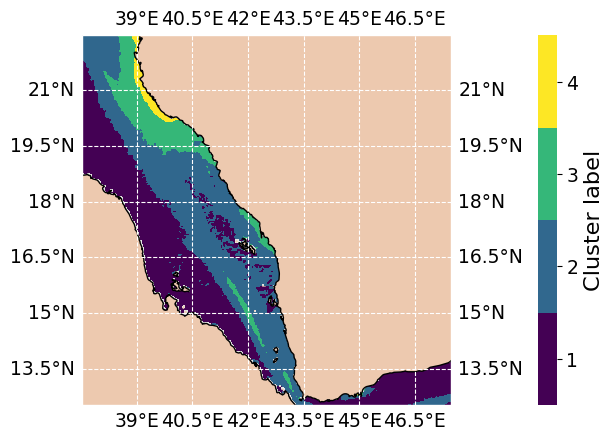

In [161]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot clustered data
no2_clim_min, no2_clim_max = np.nanmin(no2_kmeans_label), np.nanmax(no2_kmeans_label)
plt.imshow(no2_kmeans_label, cmap = matplotlib.cm.get_cmap("viridis", optimal_k),
           extent=[extent[0], extent[1], extent[2], extent[3]],
           vmin = np.nanmin(no2_kmeans_label), vmax = np.nanmax(no2_kmeans_label))
cbar = plt.colorbar(fraction=0.0426, pad=0.175, label='Cluster label')
labels = np.linspace(no2_clim_min, no2_clim_max, optimal_k, dtype='int32')
loc = 0.75 * labels + 0.625
cbar.set_ticks(loc)
cbar.set_ticklabels(labels)
cbar.outline.set_edgecolor(None)
plt.show()

Perform statistical analysis

In [162]:
## Prepare data
NO2 = copy.deepcopy(no2_kmeans_label).reshape(-1, 1)
SHIP_TRACK = copy.deepcopy(ship_freq).reshape(-1, 1)
mask = ~np.isnan(NO2) & ~np.isnan(SHIP_TRACK)
X = NO2[mask].reshape(-1, 1)
y = SHIP_TRACK[mask]

## Pearson correlation
print('Spatial correlation between NO2 column level & ship track counts:', stats.pearsonr(NO2[mask], SHIP_TRACK[mask]))

# Fit OLS model
m2 = spreg.OLS(
    # Dependent variable
    y,
    # Independent variables
    X,
    # Dependent variable name
    name_y='Ship track', 
    # Independent variable name
    name_x=['NO2 cluster w/o ConvGi*']
)
print(m2.summary)

Spatial correlation between NO2 column level & ship track counts: PearsonRResult(statistic=0.2548698062212451, pvalue=0.0)
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  Ship track                Number of Observations:       27214
Mean dependent var  :      0.1241                Number of Variables   :           2
S.D. dependent var  :      0.1704                Degrees of Freedom    :       27212
R-squared           :      0.0650
Adjusted R-squared  :      0.0649
Sum squared residual:     738.788                F-statistic           :   1890.4553
Sigma-square        :       0.027                Prob(F-statistic)     :           0
S.E. of regression  :       0.165                Log likelihood        :   10458.324
Sigma-square ML     :       0.027                Akaike info criterion :  -20912.648
S.E of regression ML:      0.1648       

Calculate statistics per cluster (mean & std)

In [163]:
## Store the cluster labels as a mask
dict_cluster = {}
for i in range(optimal_k):
    tmp = copy.deepcopy(no2_kmeans_label)
    tmp = tmp / (i + 1)
    tmp[tmp != 1] = np.nan
    dict_cluster[i + 1] = tmp

## Copy data
no2_vcd_copied = copy.deepcopy(no2_vcd)
ship_freq_copied = copy.deepcopy(ship_freq)

## Define rounding function to designated significant numbers
def round_sf(number, significant):
    return round(number, significant - int(np.floor(np.log10(abs(number)))) - 1)

## Calculate mean and std per cluster
dict_stat_per_cluster = {}
for i in range(1, optimal_k+1):
    dict_stat_per_cluster[i] = round_sf(np.nanmean(np.multiply(no2_vcd_copied, dict_cluster[i])), 4), round_sf(np.nanstd(np.multiply(no2_vcd_copied, dict_cluster[i])), 4)
print('Statistics of no2 measurement per cluster (mean, std):\n', dict_stat_per_cluster)

## Calculate shipping frequency per cluster
dict_ship_freq_per_cluster = {}
for i in range(1, optimal_k+1):
    dict_ship_freq_per_cluster[i] = round_sf(np.nanmean(np.multiply(ship_freq_copied, dict_cluster[i])), 4), round_sf(np.nanstd(np.multiply(ship_freq_copied, dict_cluster[i])), 4)
print('Statistics of shipping frequency per cluster (mean, std):\n', dict_ship_freq_per_cluster)

del i, tmp, no2_vcd_copied, ship_freq_copied

Statistics of no2 measurement per cluster (mean, std):
 {1: (1.19e-05, 5.749e-06), 2: (1.476e-05, 7.221e-06), 3: (1.924e-05, 1.3e-05), 4: (3.291e-05, 2.933e-05)}
Statistics of shipping frequency per cluster (mean, std):
 {1: (0.04856, 0.05814), 2: (0.19, 0.1991), 3: (0.1547, 0.2106), 4: (0.03216, 0.01366)}


Plot box plot of clustered NO2 data

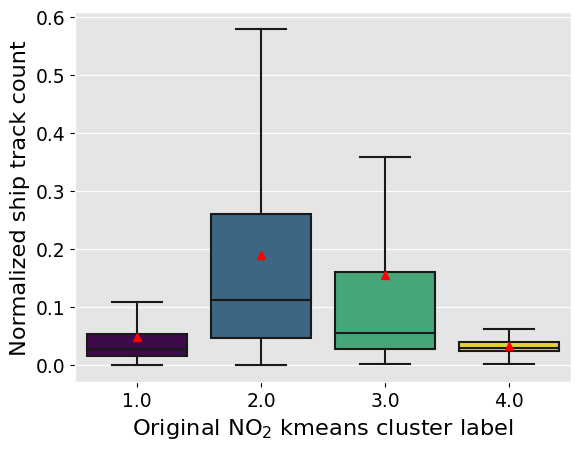

In [164]:
## Prepare clustered data
NO2_cluster = no2_kmeans_label.reshape(-1, 1)
SHIP_TRACK = copy.deepcopy(ship_freq).reshape(-1, 1)
mask = ~np.isnan(NO2_cluster) & ~np.isnan(SHIP_TRACK)
color_palette_viridis = [ "#440154", "#31688e", "#35b779", "#fde725"]

## Box plot of NO2 clustered data
fig_boxplot = sns.boxplot(x='NO2_cluster', y='Ship', data={'NO2_cluster': NO2_cluster[mask], 'Ship': SHIP_TRACK[mask]}, palette=color_palette_viridis,                          
                          showfliers=False, showmeans=True, meanprops={"markerfacecolor":"red", "markeredgecolor":"red"})
fig_boxplot.set(xlabel='Original NO$_2$ kmeans cluster label', ylabel='Normalized ship track count')
plt.show()

## Perform clustering on NO<sub>2</sub> using $ConvG_i^*$

Calculate $ConvG_i^*$

In [165]:
# Calculate ConvGistar
no2_ConvGistar = ConvGistar(np.multiply(copy.deepcopy(no2_vcd), ocean_mask))

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1733344371.py:13: RuntimeWarning: Mean of empty slice
  Xbar = np.nanmean(input_array, axis=(1, 2))
C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1733344371.py:16: RuntimeWarning: invalid value encountered in sqrt
  ConvGistar[i] = (convolve(input_array[i], kernel, boundary='fill', fill_value=np.nan, preserve_nan=True, normalize_kernel=False) - Xbar[i]*np.nansum(kernel)) / (np.sqrt(convolve(np.square(input_array[i]), kernel, boundary='fill', fill_value=np.nan, preserve_nan=True, normalize_kernel=False) - np.square(Xbar[i])) * np.sqrt((n*np.nansum(np.square(kernel)) - np.square(np.nansum(kernel))) / (n - 1)))


Plot $ConvG_i^*$

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\3480140044.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cmap='viridis',


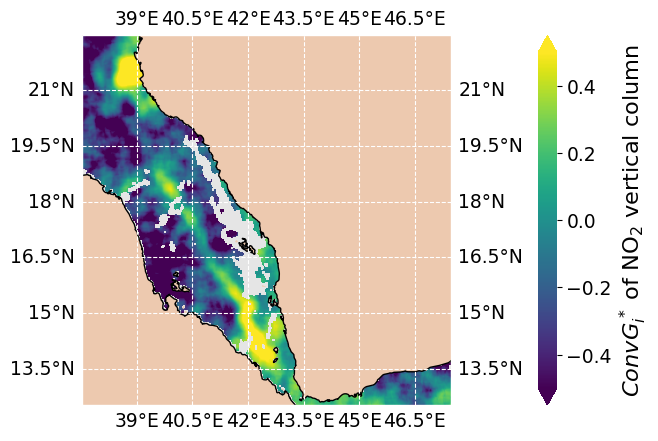

In [166]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot clustered data
plt.imshow(copy.deepcopy(no2_ConvGistar)[888, :, :], # May 11th 2021
           cmap='viridis', extent=[extent[0], extent[1], extent[2], extent[3]], vmin=-.5, vmax=.5)
plt.colorbar(cmap='viridis',
             fraction=0.0426, pad=0.175, extend='both',
             label='$ConvG_i^*$ of NO$_{2}$ vertical column').outline.set_edgecolor(None)
plt.show()

## Exclude near-coast coordinates

Build mask to filter out land & near-coast coordinates

In [167]:
# Build ocean_mask_far_coast
x, y = np.array(lons), np.array(lats)
xx, yy = np.meshgrid(x, y, sparse=True)
land = prep(unary_union(list(cartopy.io.shapereader.Reader(cartopy.io.shapereader.natural_earth(resolution='10m', category='physical', name='land')).geometries())))
ocean_mask_far_coast = np.empty([len(lats), len(lons)])
for i in range(len(lons)):
    for j in range(len(lats)):
        ocean_mask_far_coast[j, i] = not is_land(land, x[i], y[j])
land_mask = -(ocean_mask_far_coast) + 1

rad = 20 # hyperparameter of kernel radius
kernel_xx, kernel_yy = np.meshgrid(np.arange(-rad, rad + 1, 1), np.arange(-rad, rad + 1, 1))
kernel_near_coast = np.square(kernel_xx) + np.square(kernel_yy) <= np.square(rad)
ocean_mask_far_coast = -(convolve2d(land_mask.astype(int), kernel_near_coast.astype(int), mode='same').astype(bool).astype(float)) + 1
ocean_mask_far_coast[ocean_mask_far_coast == 0] = np.nan
no2_vcd_far_coast = np.multiply(copy.deepcopy(no2_vcd), ocean_mask_far_coast)

del rad

Plot near-coast filtered ocean coordinates

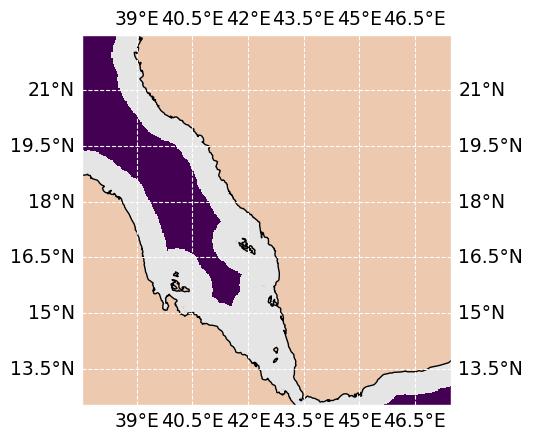

In [168]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot ocean-coordinates only
plt.imshow(ocean_mask_far_coast, extent=[extent[0], extent[1], extent[2], extent[3]], cmap='viridis')
plt.show()

Plot near-coast filtered true shipping frequency

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2621067707.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(matplotlib.cm.ScalarMappable(cmap='viridis'),


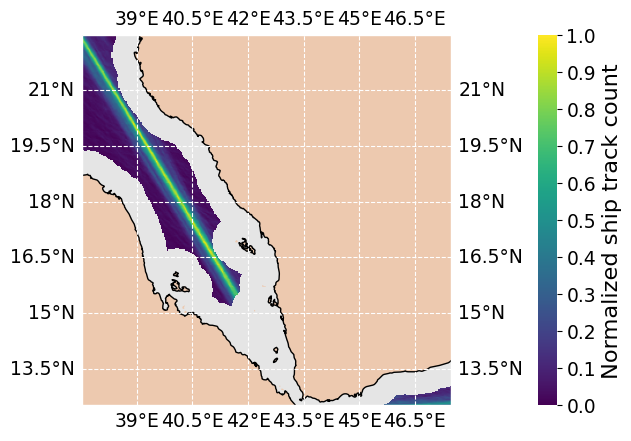

In [169]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot true shipping frequency
img = np.multiply(ship_freq[:, :], ocean_mask_far_coast)
plt.imshow(img, extent=[extent[0], extent[1], extent[2], extent[3]], cmap='viridis')
plt.colorbar(matplotlib.cm.ScalarMappable(cmap='viridis'),
             fraction=0.0426, pad = 0.175, extend='neither', ax=plt.gca(),
             ticks=np.linspace(np.floor(np.nanmin(img)*100)/100, np.ceil(np.nanmax(img)*100)/100, 11),
             label='Normalized ship track count').outline.set_edgecolor(None)
plt.show()

del img

Plot near-coast filtered daily measurement data

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\4234415609.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cmap='viridis', fraction=0.0426, pad=0.175, extend='both',


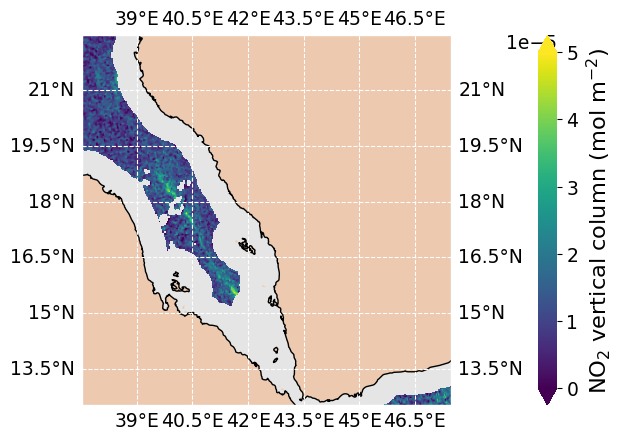

In [170]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot daily measurement data
plt.imshow(copy.deepcopy(no2_vcd_far_coast)[888, :, :], # May 11th 2021
           cmap='viridis', extent=[extent[0], extent[1], extent[2], extent[3]], vmin=0, vmax=0.00005)
plt.colorbar(cmap='viridis', fraction=0.0426, pad=0.175, extend='both',
             label='NO$_{2}$ vertical column (mol m$^{-2}$)').outline.set_edgecolor(None)
plt.show()

Inspect how near-coast removal effectively removes outliers (compared to original NO2 data scatter plot)

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\611056011.py:2: RuntimeWarning: Mean of empty slice
  NO2 = np.nanmean(copy.deepcopy(no2_vcd_far_coast)[:, :, :], axis=0).reshape(-1, 1)


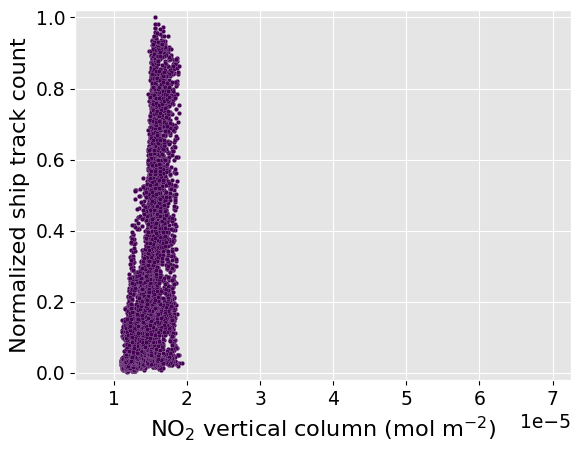

In [171]:
## Prepare data
NO2 = np.nanmean(copy.deepcopy(no2_vcd_far_coast)[:, :, :], axis=0).reshape(-1, 1)
SHIP_TRACK = copy.deepcopy(ship_freq).reshape(-1, 1)
mask = ~np.isnan(NO2) & ~np.isnan(SHIP_TRACK)

## Scatter plot of NO2 data
fig_boxplot = sns.scatterplot(x=NO2[mask], y=SHIP_TRACK[mask], alpha=1, color='#440154', linewidth=0.1, s=10)
fig_boxplot.set(xlabel='NO$_2$ vertical column (mol m$^{-2}$)',
                ylabel='Normalized ship track count',
                ylim = (-0.02, 1.02),
                xlim = (0.99 * min_before_outlier_removal, 1.01 * max_before_outlier_removal))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.show()

## Perform clustering on near-coast excluded NO<sub>2</sub> using $ConvG_i^*$

Calculate $ConvG_i^*$

In [172]:
# Calculate ConvGistar
no2_vcd_ConvGistar = ConvGistar(copy.deepcopy(no2_vcd_far_coast))

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1733344371.py:13: RuntimeWarning: Mean of empty slice
  Xbar = np.nanmean(input_array, axis=(1, 2))
C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1733344371.py:16: RuntimeWarning: invalid value encountered in sqrt
  ConvGistar[i] = (convolve(input_array[i], kernel, boundary='fill', fill_value=np.nan, preserve_nan=True, normalize_kernel=False) - Xbar[i]*np.nansum(kernel)) / (np.sqrt(convolve(np.square(input_array[i]), kernel, boundary='fill', fill_value=np.nan, preserve_nan=True, normalize_kernel=False) - np.square(Xbar[i])) * np.sqrt((n*np.nansum(np.square(kernel)) - np.square(np.nansum(kernel))) / (n - 1)))


Plot $ConvG_i^*$

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\3047193319.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cmap='viridis', fraction=0.0426, pad=0.175, extend='both',


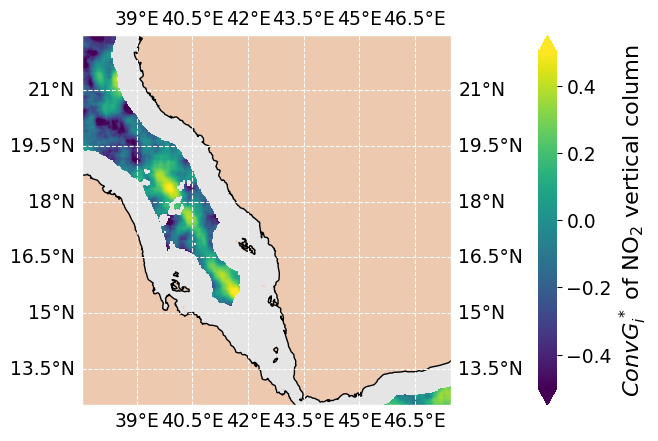

In [173]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot daily measurement data
plt.imshow(copy.deepcopy(no2_vcd_ConvGistar)[888, :, :], # May 11th 2021
           cmap='viridis', extent=[extent[0], extent[1], extent[2], extent[3]], vmin=-.5, vmax=.5)
plt.colorbar(cmap='viridis', fraction=0.0426, pad=0.175, extend='both',
             label='$ConvG_i^*$ of NO$_{2}$ vertical column').outline.set_edgecolor(None)
plt.show()

Perform clustering on $ConvG_i^*$

In [174]:
# NO$_{2}$ values excluding NaN
clustered_no2_vcd = np.nanmean(no2_vcd_ConvGistar, axis=0)
X = clustered_no2_vcd[~np.isnan(clustered_no2_vcd)].reshape(-1, 1)

# Run k means and store its label
kmeans_fit = KMeans(init='k-means++', n_clusters=optimal_k, random_state=1).fit(X)
idx = np.argsort(kmeans_fit.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(optimal_k)
kmeans_fit_lab = lut[kmeans_fit.labels_] + 1
print("K-means label of NO2:\n", kmeans_fit_lab)

# Mask k means label of land coordinates
np_zeros = np.zeros([len(lats), len(lons)], dtype=int)
ocean_idx = np.where(ocean_mask_far_coast.flatten() == 1)
np.put(np_zeros, ocean_idx, kmeans_fit_lab)
no2_ConvGistar_kmeans_label = np.multiply(np_zeros, ocean_mask_far_coast)

del clustered_no2_vcd, X, kmeans_fit, idx, lut, kmeans_fit_lab, np_zeros, ocean_idx

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2574907732.py:2: RuntimeWarning: Mean of empty slice
  clustered_no2_vcd = np.nanmean(no2_vcd_ConvGistar, axis=0)
c:\Users\kimsa\OneDrive - g.skku.edu\1_Research\1_NO2\1_Analysis\Code\no2clu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-means label of NO2:
 [3 3 3 ... 2 2 2]


Plot clustered $ConvG_i^*$ data

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1800621906.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(fraction=0.0426, pad=0.175, label='Cluster label')


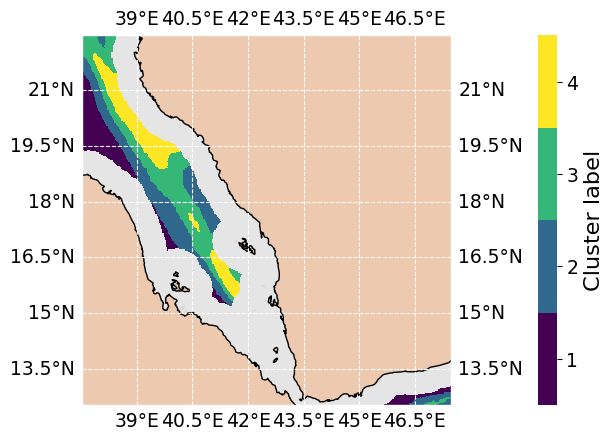

In [175]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Plot clustered data
no2_clim_min, no2_clim_max = np.nanmin(no2_ConvGistar_kmeans_label), np.nanmax(no2_ConvGistar_kmeans_label)
plt.imshow(no2_ConvGistar_kmeans_label, cmap = matplotlib.cm.get_cmap("viridis", optimal_k),
           extent=[extent[0], extent[1], extent[2], extent[3]],
           vmin = np.nanmin(no2_ConvGistar_kmeans_label), vmax = np.nanmax(no2_ConvGistar_kmeans_label))
cbar = plt.colorbar(fraction=0.0426, pad=0.175, label='Cluster label')
labels = np.linspace(no2_clim_min, no2_clim_max, optimal_k, dtype='int32')
loc = 0.75 * labels + 0.625
cbar.set_ticks(loc)
cbar.set_ticklabels(labels)
cbar.outline.set_edgecolor(None)
plt.show()

Perform statistical analysis

In [176]:
## Prepare data
NO2_ConvGistar_cluster = copy.deepcopy(no2_ConvGistar_kmeans_label).reshape(-1,1)
SHIP_TRACK = ship_freq.reshape(-1,1)
mask = ~np.isnan(NO2_ConvGistar_cluster) & ~np.isnan(SHIP_TRACK)
X = NO2[mask].reshape(-1, 1)
y = SHIP_TRACK[mask]

## Pearson correlation
print('Spatial correlation between NO2 column level & ship track counts:', stats.pearsonr(NO2_ConvGistar_cluster[mask], SHIP_TRACK[mask]))

# Fit OLS model
m3 = spreg.OLS(
    # Dependent variable
    y,
    # Independent variables
    X,
    # Dependent variable name
    name_y='Ship track', 
    # Independent variable name
    name_x=['NO2 cluster with ConvGi*']
)
print(m3.summary)

Spatial correlation between NO2 column level & ship track counts: PearsonRResult(statistic=0.6150124429849572, pvalue=0.0)
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  Ship track                Number of Observations:       10576
Mean dependent var  :      0.2035                Number of Variables   :           2
S.D. dependent var  :      0.2266                Degrees of Freedom    :       10574
R-squared           :      0.3769
Adjusted R-squared  :      0.3769
Sum squared residual:     338.186                F-statistic           :   6396.9038
Sigma-square        :       0.032                Prob(F-statistic)     :           0
S.E. of regression  :       0.179                Log likelihood        :    3198.550
Sigma-square ML     :       0.032                Akaike info criterion :   -6393.100
S.E of regression ML:      0.1788       

Calculate statistics per cluster (mean & std)

In [177]:
## Store the cluster labels as a mask
dict_ConvGistar_cluster = {}
for i in range(optimal_k):
    tmp = copy.deepcopy(no2_ConvGistar_kmeans_label)
    tmp = tmp / (i + 1)
    tmp[tmp != 1] = np.nan
    dict_ConvGistar_cluster[i + 1] = tmp

## Copy data
no2_vcd_copied = copy.deepcopy(no2_vcd)
ship_freq_copied = copy.deepcopy(ship_freq)

## Define rounding function to designated significant numbers
def round_sf(number, significant):
    return round(number, significant - int(np.floor(np.log10(abs(number)))) - 1)

## Calculate mean and std per cluster
dict_stat_per_cluster = {}
for i in range(1, optimal_k+1):
    dict_stat_per_cluster[i] = round_sf(np.nanmean(np.multiply(no2_vcd_copied, dict_ConvGistar_cluster[i])), 4), round_sf(np.nanstd(np.multiply(no2_vcd_copied, dict_ConvGistar_cluster[i])), 4)
print('Statistics of no2 measurement per cluster (mean, std):\n', dict_stat_per_cluster)

## Calculate shipping frequency per cluster
dict_ship_freq_per_cluster = {}
for i in range(1, optimal_k+1):
    dict_ship_freq_per_cluster[i] = round_sf(np.nanmean(np.multiply(ship_freq_copied, dict_ConvGistar_cluster[i])), 4), round_sf(np.nanstd(np.multiply(ship_freq_copied, dict_ConvGistar_cluster[i])), 4)
print('Statistics of shipping frequency per cluster (mean, std):\n', dict_ship_freq_per_cluster)

del i, tmp, no2_vcd_copied, ship_freq_copied

Statistics of no2 measurement per cluster (mean, std):
 {1: (1.199e-05, 5.889e-06), 2: (1.336e-05, 6.554e-06), 3: (1.48e-05, 7.591e-06), 4: (1.674e-05, 9.388e-06)}
Statistics of shipping frequency per cluster (mean, std):
 {1: (0.05351, 0.06393), 2: (0.07447, 0.07824), 3: (0.2801, 0.2157), 4: (0.4365, 0.2597)}


Plot box plot of clustered $ConvG_i^*$ data

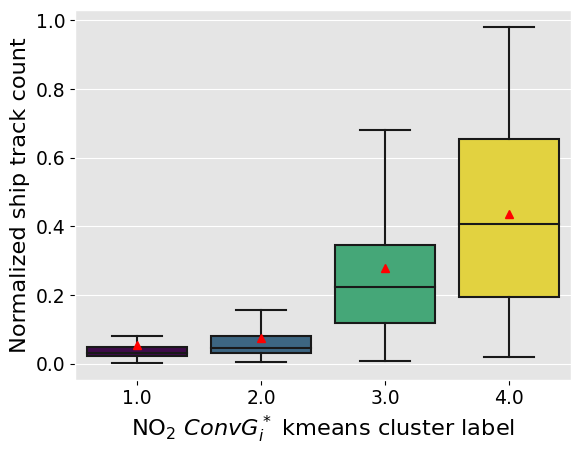

In [178]:
## Prepare clustered data
NO2_cluster = no2_ConvGistar_kmeans_label.reshape(-1, 1)
SHIP_TRACK = copy.deepcopy(ship_freq).reshape(-1, 1)
mask = ~np.isnan(NO2_cluster) & ~np.isnan(SHIP_TRACK)

## Box plot of NO2 clustered data
fig_boxplot = sns.boxplot(x='NO2_cluster', y='Ship', data={'NO2_cluster': NO2_cluster[mask], 'Ship': SHIP_TRACK[mask]}, palette=color_palette_viridis,
                          showfliers=False, showmeans=True, meanprops={"markerfacecolor":"red", "markeredgecolor":"red"})
fig_boxplot.set(xlabel='NO$_2$ $ConvG_i^*$ kmeans cluster label', ylabel='Normalized ship track count')
plt.show()

---
## Perform temporal analysis

For temporal analysis, we focus on the comparison between shipping route (cluster with the highest label) and background (cluster with the lowest label).

Plot shipping route (cluster with the highest label) from clustered $ConvG_i^*$ data

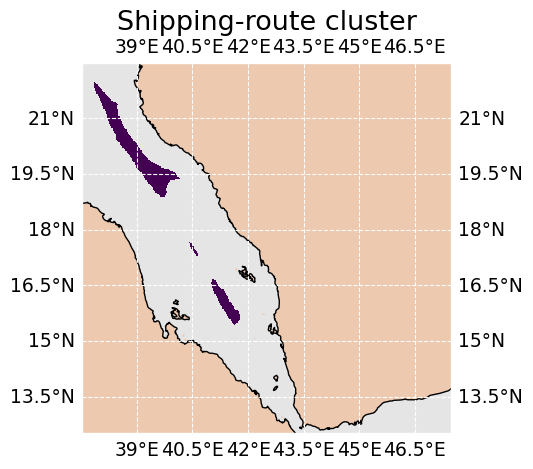

In [179]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Build shipping-route mask
no2_ConvGistar_shipping = copy.deepcopy(no2_ConvGistar_kmeans_label)
no2_ConvGistar_shipping[no2_ConvGistar_shipping != optimal_k] = np.nan
no2_ConvGistar_shipping = no2_ConvGistar_shipping / optimal_k

## Plot clustered data masked by shipping-route mask
plt.imshow(no2_ConvGistar_shipping, cmap = matplotlib.cm.get_cmap("viridis", optimal_k),
           extent=[extent[0], extent[1], extent[2], extent[3]])
plt.title('Shipping-route cluster')
plt.show()

Plot background (cluster with the lowest label) from clustered $ConvG_i^*$ data

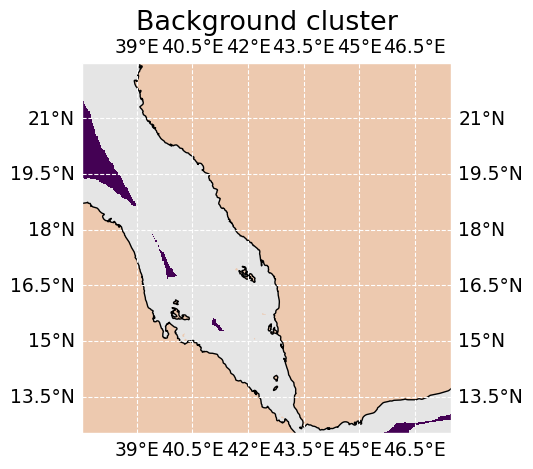

In [180]:
## Plot base map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=1, facecolor='#edc9af', alpha=1)
ax.add_feature(cart.feature.COASTLINE, linewidth=1, edgecolor='black')
ax.gridlines(draw_labels=True, linestyle='--')

## Build background mask
no2_ConvGistar_background = copy.deepcopy(no2_ConvGistar_kmeans_label)
no2_ConvGistar_background[no2_ConvGistar_background != 1] = np.nan
# no2_ConvGistar_background = no2_ConvGistar_shipping / 1

## Plot clustered data masked by background mask
plt.imshow(no2_ConvGistar_background, cmap = matplotlib.cm.get_cmap("viridis", optimal_k),
           extent=[extent[0], extent[1], extent[2], extent[3]])
plt.title('Background cluster')
plt.show()

Generate monthly timestamp

In [181]:
## Generate monthly timestamp
## Monthly timestamp: first-day indices from Dec. 5th 2018 to Nov. 10th 2021 (total 1,072 days)
month_index = [0,
               27, 58, 86, 117, 147, 178, 208, 239, 270, 300, 331, 361,
               392, 423, 452, 483, 513, 544, 574, 605, 636, 666, 697, 727,
               758, 789, 817, 848, 878, 909, 939, 970, 1001, 1031, 1062, 1072]
month_name = ['Dec. 2018',
              'Jan. 2019', 'Feb. 2019', 'Mar. 2019', 'Apr. 2019', 'May. 2019', 'Jun. 2019', 'Jul. 2019', 'Aug. 2019', 'Sep. 2019', 'Oct. 2019', 'Nov. 2019', 'Dec. 2019',
              'Jan. 2020', 'Feb. 2020', 'Mar. 2020', 'Apr. 2020', 'May. 2020', 'Jun. 2020', 'Jul. 2020', 'Aug. 2020', 'Sep. 2020', 'Oct. 2020', 'Nov. 2020', 'Dec. 2020',
              'Jan. 2021', 'Feb. 2021', 'Mar. 2021', 'Apr. 2021', 'May. 2021', 'Jun. 2021', 'Jul. 2021', 'Aug. 2021', 'Sep. 2021', 'Oct. 2021', 'Nov. 2021']
month = {}
for i in range(len(month_index) - 1):
    month["{0}".format(i)] = range(month_index[i], month_index[i + 1])

Calculate monthly statistics per clusters (e.g. shipping route vs. background)

In [182]:
## Calculate monthly mean & std
no2_monthly_mean_shipping = {}
no2_monthly_mean_background = {}
no2_monthly_std_shipping = {}
no2_monthly_std_background = {}
for i in range(len(month_index) - 1):
    no2_monthly_mean_shipping["{0}".format(i)] = np.nanmean(np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[month[str(i)], :, :], no2_ConvGistar_shipping), axis=0))
    no2_monthly_mean_background["{0}".format(i)] = np.nanmean(np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[month[str(i)], :, :], no2_ConvGistar_background), axis=0))
    no2_monthly_std_shipping["{0}".format(i)] = np.nanstd(np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[month[str(i)], :, :], no2_ConvGistar_shipping), axis=0))
    no2_monthly_std_background["{0}".format(i)] = np.nanstd(np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[month[str(i)], :, :], no2_ConvGistar_background), axis=0))

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2877697488.py:7: RuntimeWarning: Mean of empty slice
  no2_monthly_mean_shipping["{0}".format(i)] = np.nanmean(np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[month[str(i)], :, :], no2_ConvGistar_shipping), axis=0))
C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2877697488.py:8: RuntimeWarning: Mean of empty slice
  no2_monthly_mean_background["{0}".format(i)] = np.nanmean(np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[month[str(i)], :, :], no2_ConvGistar_background), axis=0))
C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2877697488.py:9: RuntimeWarning: Mean of empty slice
  no2_monthly_std_shipping["{0}".format(i)] = np.nanstd(np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[month[str(i)], :, :], no2_ConvGistar_shipping), axis=0))
C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2877697488.py:10: RuntimeWarning: Mean of empty slice
  no2_monthly_std_background["{0}".format(i)] = np.nanstd(np.nanmean(np.multiply(copy.deepcopy(no2_vcd)[mo

Plot the trend of monthly statistics in shipping route cluster

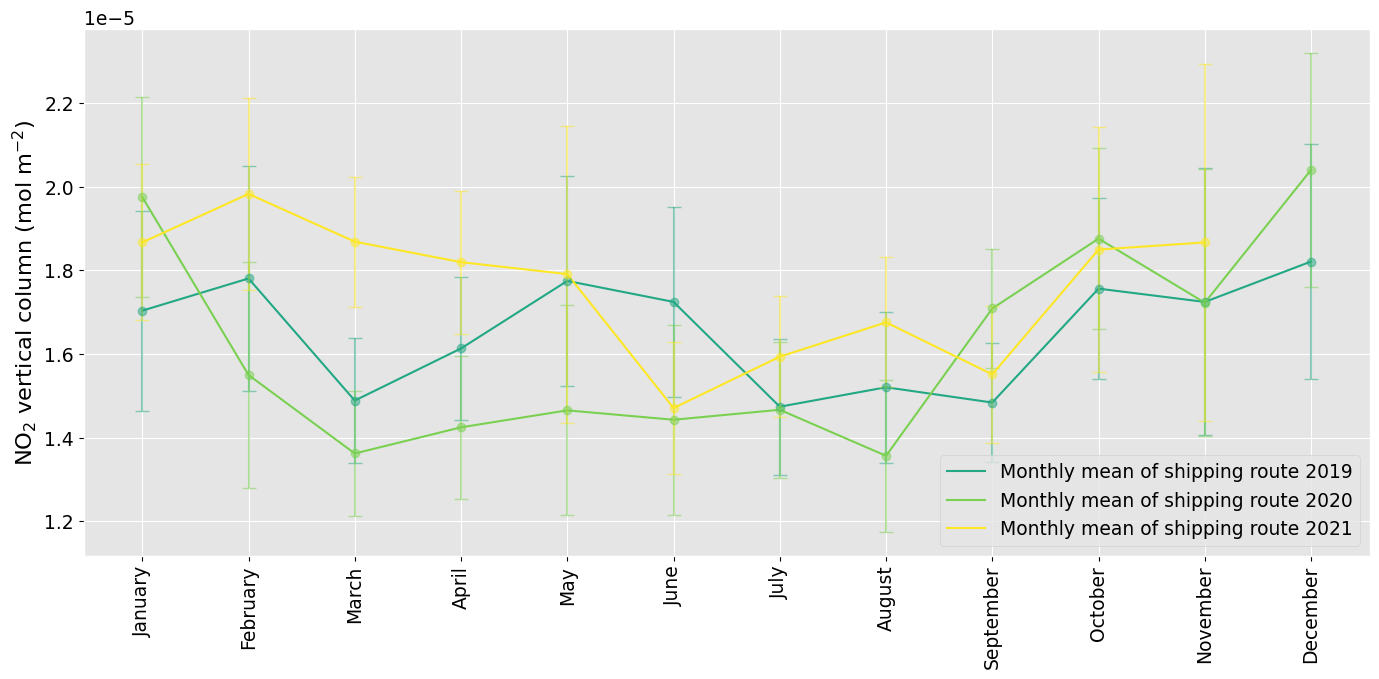

In [183]:
## Prepare data
x = np.array(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
y1 = [*no2_monthly_mean_shipping.values()][1:13]
y2 = [*no2_monthly_mean_shipping.values()][13:25]
y3 = [*no2_monthly_mean_shipping.values()][25:]
y1err = [*no2_monthly_std_shipping.values()][1:13]
y2err = [*no2_monthly_std_shipping.values()][13:25]
y3err = [*no2_monthly_std_shipping.values()][25:]

## Plot trend time series
plt.figure(figsize=(14, 7))
plt.plot(x, y1, label='Monthly mean of shipping route 2019', color='#22a884')
plt.errorbar(x, y1, yerr=y1err, fmt='o', capsize=5, alpha=0.5, color='#22a884')
plt.plot(x, y2, label='Monthly mean of shipping route 2020', color='#7ad151')
plt.errorbar(x, y2, yerr=y1err, fmt='o', capsize=5, alpha=0.5, color='#7ad151')
plt.plot(range(len(y3)), y3, label='Monthly mean of shipping route 2021', color='#fde725')
plt.errorbar(range(len(y3)), y3, yerr=y3err, fmt='o', capsize=5, alpha=0.5, color='#fde725')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-5, -5))
plt.xticks(rotation = 90)
plt.ylabel('NO$_2$ vertical column (mol m$^{-2}$)')
plt.legend()
plt.tight_layout()
plt.show()

Plot the trend of monthly statistics in background cluster

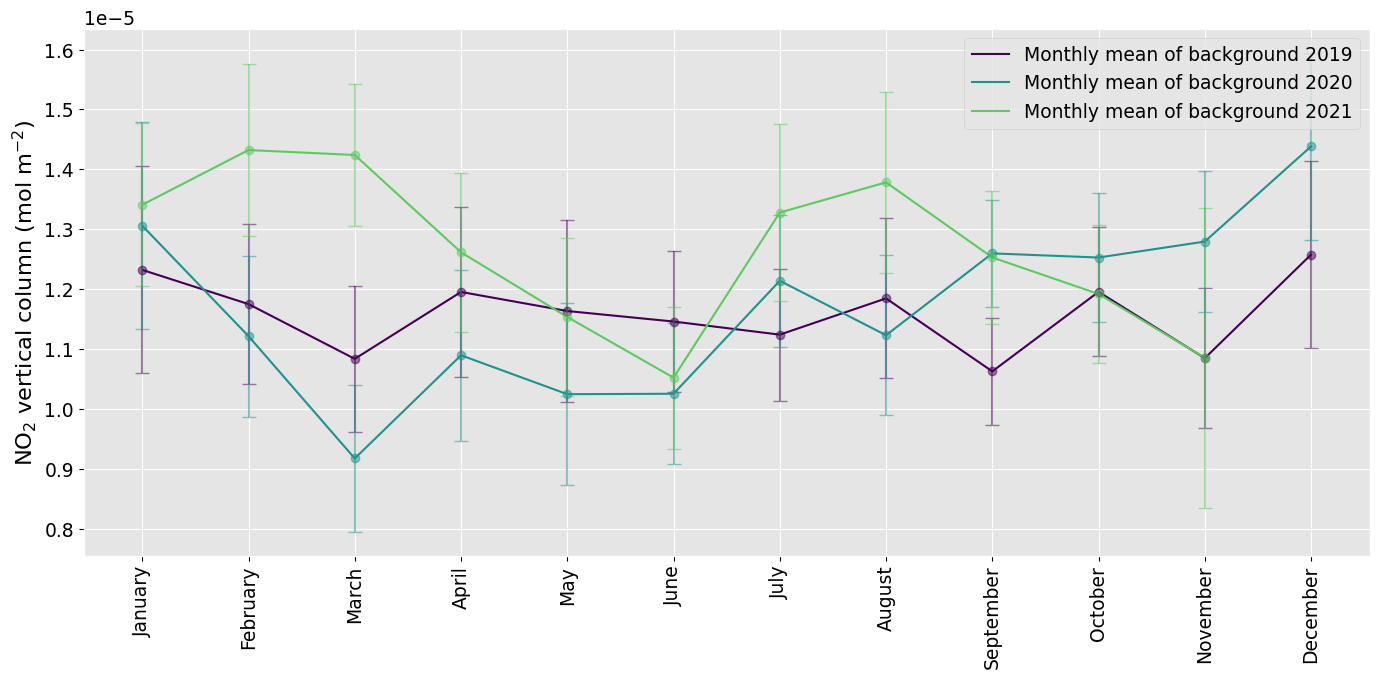

In [184]:
## Prepare data
x = np.array(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
y1 = [*no2_monthly_mean_background.values()][1:13]
y2 = [*no2_monthly_mean_background.values()][13:25]
y3 = [*no2_monthly_mean_background.values()][25:]
y1err = [*no2_monthly_std_background.values()][1:13]
y2err = [*no2_monthly_std_background.values()][13:25]
y3err = [*no2_monthly_std_background.values()][25:]

## Plot trend time series
plt.figure(figsize=(14, 7))
plt.plot(x, y1, label='Monthly mean of background 2019', color='#440154')
plt.errorbar(x, y1, yerr=y1err, fmt='o', capsize=5, alpha=0.5, color='#440154')
plt.plot(x, y2, label='Monthly mean of background 2020', color='#21918c')
plt.errorbar(x, y2, yerr=y1err, fmt='o', capsize=5, alpha=0.5, color='#21918c')
plt.plot(range(len(y3)), y3, label='Monthly mean of background 2021', color='#5ec962')
plt.errorbar(range(len(y3)), y3, yerr=y3err, fmt='o', capsize=5, alpha=0.5, color='#5ec962')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-5, -5))
plt.xticks(rotation = 90)
plt.ylabel('NO$_2$ vertical column (mol m$^{-2}$)')
plt.legend()
plt.tight_layout()
plt.show()

Plot the trend of monthly statistics in shipping route cluster & background cluster

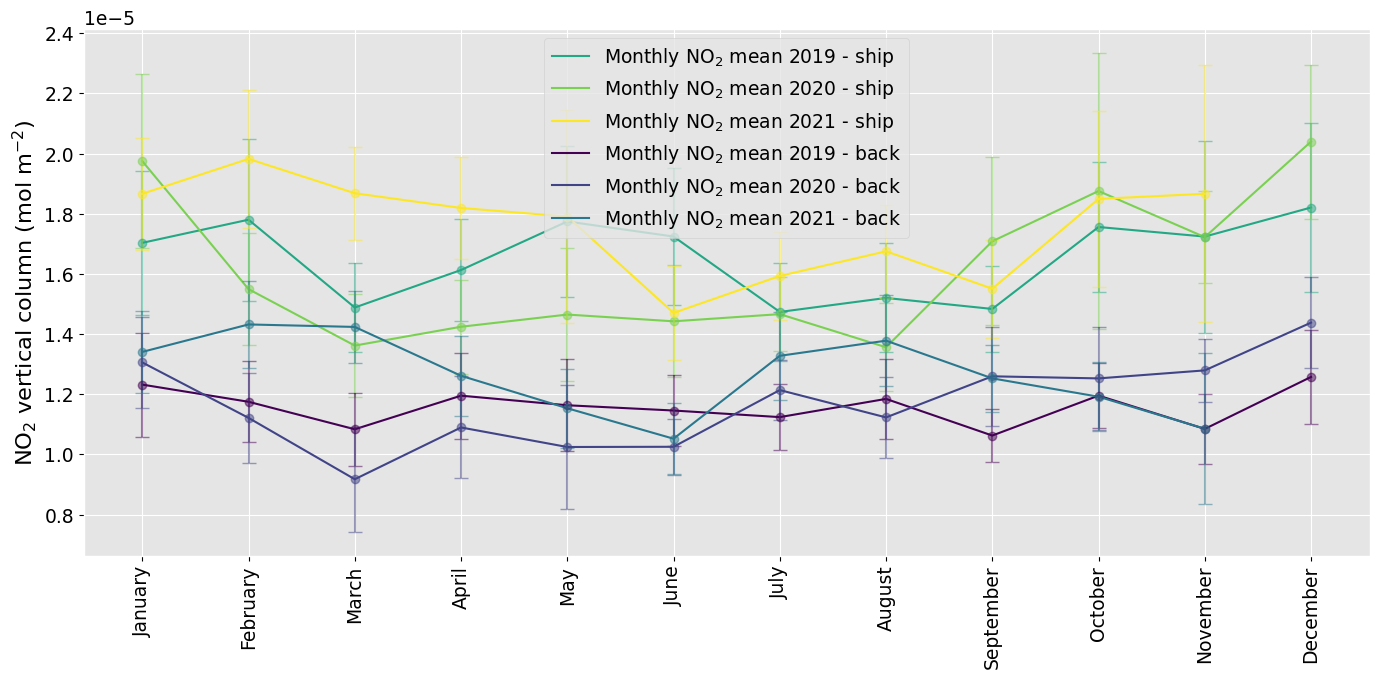

In [185]:
## Prepare data
x = np.array(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
y1_ship = [*no2_monthly_mean_shipping.values()][1:13]
y2_ship = [*no2_monthly_mean_shipping.values()][13:25]
y3_ship = [*no2_monthly_mean_shipping.values()][25:]
y1_back = [*no2_monthly_mean_background.values()][1:13]
y2_back = [*no2_monthly_mean_background.values()][13:25]
y3_back = [*no2_monthly_mean_background.values()][25:]
y1err_ship = [*no2_monthly_std_shipping.values()][1:13]
y2err_ship = [*no2_monthly_std_shipping.values()][13:25]
y3err_ship = [*no2_monthly_std_shipping.values()][25:]
y1err_back = [*no2_monthly_std_background.values()][1:13]
y2err_back = [*no2_monthly_std_background.values()][13:25]
y3err_back = [*no2_monthly_std_background.values()][25:]

## Plot trend time series
plt.figure(figsize=(14, 7))
plt.plot(x, y1_ship, label='Monthly NO$_2$ mean 2019 - ship', color='#22a884')
plt.errorbar(x, y1_ship, yerr=y1err_ship, fmt='o', capsize=5, alpha=0.5, color='#22a884')
plt.plot(x, y2_ship, label='Monthly NO$_2$ mean 2020 - ship', color='#7ad151')
plt.errorbar(x, y2_ship, yerr=y2err_ship, fmt='o', capsize=5, alpha=0.5, color='#7ad151')
plt.plot(range(len(y3_ship)), y3_ship, label='Monthly NO$_2$ mean 2021 - ship', color='#fde725')
plt.errorbar(range(len(y3_ship)), y3_ship, yerr=y3err_ship, fmt='o', capsize=5, alpha=0.5, color='#fde725')
plt.plot(x, y1_back, label='Monthly NO$_2$ mean 2019 - back', color='#440154')
plt.errorbar(x, y1_back, yerr=y1err_back, fmt='o', capsize=5, alpha=0.5, color='#440154')
plt.plot(x, y2_back, label='Monthly NO$_2$ mean 2020 - back', color='#414487')
plt.errorbar(x, y2_back, yerr=y2err_back, fmt='o', capsize=5, alpha=0.5, color='#414487')
plt.plot(range(len(y3_back)), y3_back, label='Monthly NO$_2$ mean 2021 - back', color='#2a788e')
plt.errorbar(range(len(y3_back)), y3_back, yerr=y3err_back, fmt='o', capsize=5, alpha=0.5, color='#2a788e')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-5, -5))
plt.xticks(rotation = 90)
plt.ylabel("NO$_2$ vertical column (mol m$^{-2}$)")
plt.legend()
plt.tight_layout()
plt.show()

Plot the trend of monthly statistics in shipping route cluster, compared with the global container throughput index

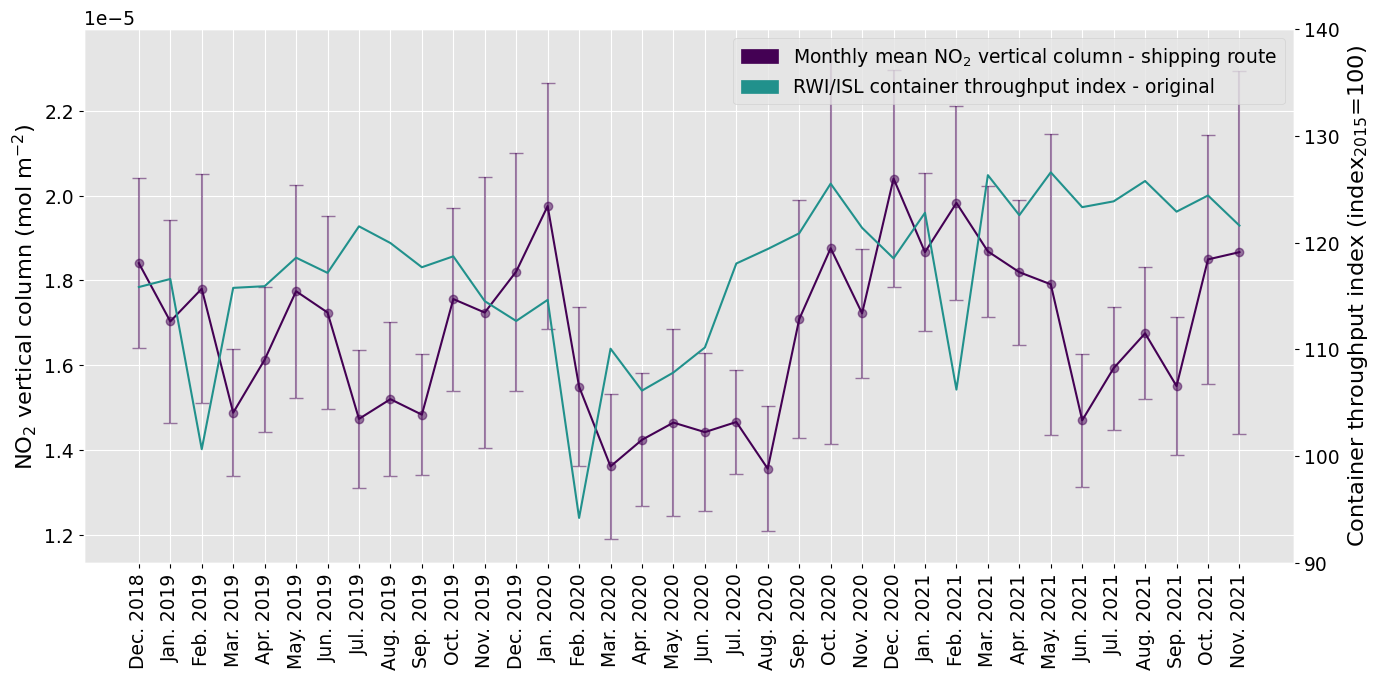

In [186]:
## Prepare data
x = np.array(month_name)
y_ship = [*no2_monthly_mean_shipping.values()]
y_back = [*no2_monthly_mean_background.values()]
yerr_ship = [*no2_monthly_std_shipping.values()]
yerr_back = [*no2_monthly_std_background.values()]
global_throughput_index = pd.read_excel('https://www.isl.org/public/containerumschlag-index/2023-04/containerumschlag-index_230531.xlsx')
start = global_throughput_index.index[global_throughput_index.iloc[:, 0] == datetime.datetime(2018, 12, 1, 0, 0)].item()
end = global_throughput_index.index[global_throughput_index.iloc[:, 0] == datetime.datetime(2021, 11, 1, 0, 0)].item()
global_throughput_original = global_throughput_index.iloc[start:(end + 1), 1].tolist()

## Plot trend time series
fig, ax1 = plt.subplots(figsize=(14, 7))
plt.xticks(rotation = 90)
plt.ylabel("NO$_2$ vertical column (mol m$^{-2}$)")
ax2 = ax1.twinx()
ax1.plot(x, y_ship, label='Monthly mean NO$_2$ vertical column - shipping route', color='#440154')
ax1.errorbar(x, y_ship, yerr=yerr_ship, fmt='o', capsize=5, alpha=0.5, color='#440154')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-5, -5))
ax2.plot(x, global_throughput_original, label='RWI/ISL container throughput index - original', color='#21918c')
ax2.grid(False)
ax2.set_ylim([90, 140])
plt.ylabel("Container throughput index (index$_{2015}$=100)")
c1_patch = mpatches.Patch(color='#440154', label='Monthly mean NO$_2$ vertical column - shipping route')
c2_patch = mpatches.Patch(color='#21918c', label='RWI/ISL container throughput index - original')
plt.legend(handles=[c1_patch, c2_patch], loc='upper right')
plt.tight_layout()
plt.show()

Perform seasonal decomposition on the data

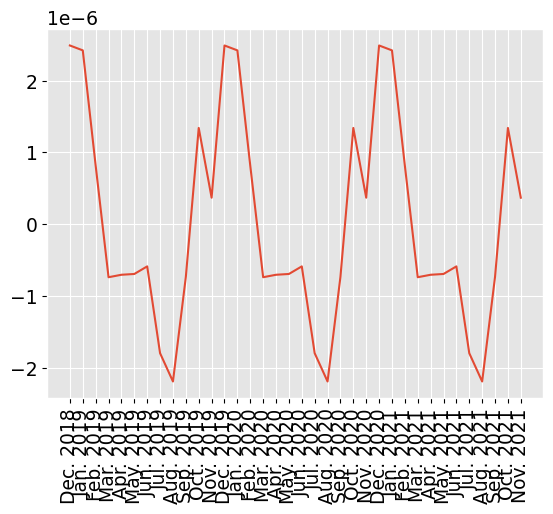

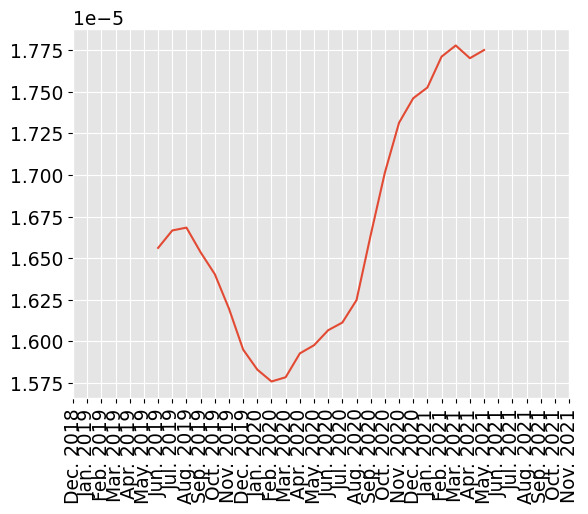

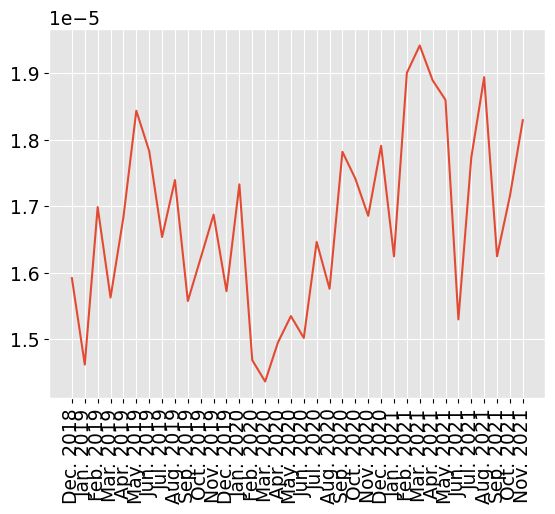

In [187]:
## Perform seasonal decomposition
seasonal_decomp = statsmodels.tsa.seasonal.seasonal_decompose(y_ship, model='additive', period=12)

## Plot seasonality
plt.plot(seasonal_decomp.seasonal)
plt.xticks(np.arange(0, 36), pd.Series(month_name), rotation = 90)
plt.show()

## Plot trend
plt.plot(seasonal_decomp.trend)
plt.xticks(np.arange(0, 36), pd.Series(month_name), rotation = 90)
plt.show()

## Plot deseasonalized NO2 data
plt.plot(y_ship - seasonal_decomp.seasonal)
plt.xticks(np.arange(0, 36), pd.Series(month_name), rotation = 90)
plt.show()

Plot the trend of deseasonalized monthly statistics in shipping route cluster, compared with the global container throughput adjusted index

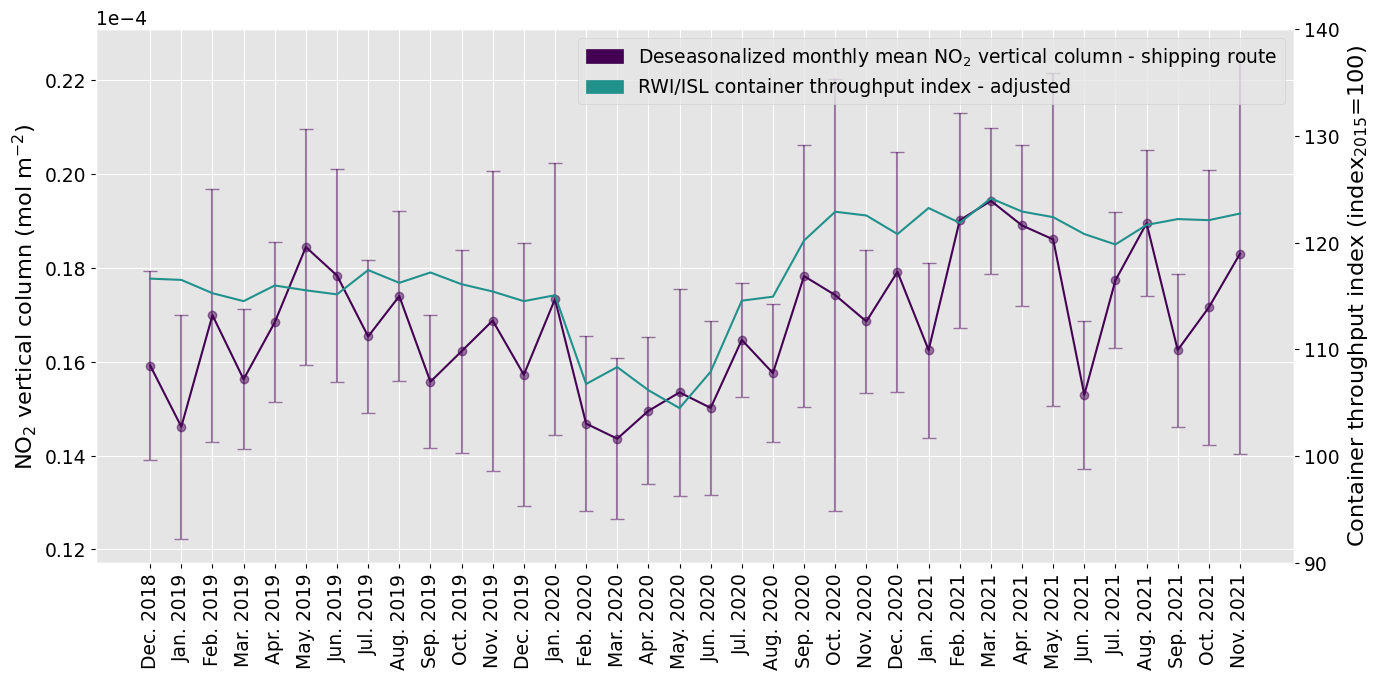

In [188]:
## Prepare data
x = np.array(month_name)
y_ship = [*no2_monthly_mean_shipping.values()]
y_back = [*no2_monthly_mean_background.values()]
yerr_ship = [*no2_monthly_std_shipping.values()]
yerr_back = [*no2_monthly_std_background.values()]
global_throughput_index = pd.read_excel('https://www.isl.org/public/containerumschlag-index/2023-04/containerumschlag-index_230531.xlsx')
start = global_throughput_index.index[global_throughput_index.iloc[:, 0] == datetime.datetime(2018, 12, 1, 0, 0)].item()
end = global_throughput_index.index[global_throughput_index.iloc[:, 0] == datetime.datetime(2021, 11, 1, 0, 0)].item()
global_throughput_adjusted = global_throughput_index.iloc[start:(end + 1), 2].tolist()

## Plot trend time series
fig, ax1 = plt.subplots(figsize=(14, 7))
plt.xticks(rotation = 90)
plt.ylabel("NO$_2$ vertical column (mol m$^{-2}$)")
ax2 = ax1.twinx()
ax1.plot(x, y_ship - seasonal_decomp.seasonal, label='Deseasonalized monthly mean NO$_2$ vertical column - shipping route', color='#440154')
ax1.errorbar(x, y_ship - seasonal_decomp.seasonal, yerr=yerr_ship, fmt='o', capsize=5, alpha=0.5, color='#440154')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
ax2.plot(x, global_throughput_adjusted, label='RWI/ISL container throughput index - adjusted', color='#21918c')
ax2.grid(False)
ax2.set_ylim([90, 140])
plt.ylabel("Container throughput index (index$_{2015}$=100)")
c1_patch = mpatches.Patch(color='#440154', label='Deseasonalized monthly mean NO$_2$ vertical column - shipping route')
c2_patch = mpatches.Patch(color='#21918c', label='RWI/ISL container throughput index - adjusted')
plt.legend(handles=[c1_patch, c2_patch], loc='upper right')
plt.tight_layout()
plt.show()

Perform statistical analysis

In [189]:
## Monthly mean NO2 on shipping route vs. global throughput index (original)
## Pearson correlation
print('Temporal Pearson correlation between shipping & throughput index (original):', stats.pearsonr(y_ship, global_throughput_original))
print('Temporal Pearson correlation between deseasonalized shipping & throughput index (adjusted):', stats.pearsonr(y_ship - seasonal_decomp.seasonal, global_throughput_adjusted))

# Calculating Kendall Rank correlation
corr, p_value = stats.kendalltau(y_ship, global_throughput_original)
print('Temporal Kendall Rank correlation (original): %.4f' % corr, ', with p-value of %.4f' % p_value)
corr, p_value = stats.kendalltau(y_ship - seasonal_decomp.seasonal, global_throughput_adjusted)
print('Temporal Kendall Rank correlation (deseasonalized & adjusted): %.4f' % corr, ', with p-value of %.4f' % p_value)

# ## Granger-Causality test 
# grangercausalitytests(pd.concat([pd.Series(y_ship), pd.Series(global_throughput_original)], axis=1), maxlag=3)
# testing whether the time series in the second column (global_throughput) Granger causes the time series in the first column (y_ship)

Temporal Pearson correlation between shipping & throughput index (original): PearsonRResult(statistic=0.19915552168301728, pvalue=0.2442327202505037)
Temporal Pearson correlation between deseasonalized shipping & throughput index (adjusted): PearsonRResult(statistic=0.6824793706183258, pvalue=4.5421484595216755e-06)
Temporal Kendall Rank correlation (original): 0.1714 , with p-value of 0.1413
Temporal Kendall Rank correlation (deseasonalized & adjusted): 0.4508 , with p-value of 0.0001


Calculate yearly mean & std per cluster

1. Shipping route

In [190]:
## Prepare data for shipping-route cluster
data_shipping = np.multiply(copy.deepcopy(no2_vcd)[:, :, :], no2_ConvGistar_shipping)
data_shipping_2019 = data_shipping[27:(27 + 365), :, :]
data_shipping_2020 = data_shipping[(27 + 365):(27 + 365 + 366), :, :]
data_shipping_2021 = data_shipping[(27 + 365 + 366):(27 + 365 + 366 + 366), :, :]

## 2019 NO2 column density
print('NO2 mean (2019):', round_sf(np.nanmean(data_shipping_2019), 4), '\nNO2 std (2019):', round_sf(np.nanstd(data_shipping_2019), 4))

## 2020 NO2 column density
print('NO2 mean (2020):', round_sf(np.nanmean(data_shipping_2020), 4), '\nNO2 std (2020):', round_sf(np.nanstd(data_shipping_2020), 4))

## 2021 NO2 column density
print('NO2 mean (2021):', round_sf(np.nanmean(data_shipping_2021), 4), '\nNO2 std (2021):', round_sf(np.nanstd(data_shipping_2021), 4))

NO2 mean (2019): 1.652e-05 
NO2 std (2019): 9.694e-06
NO2 mean (2020): 1.617e-05 
NO2 std (2020): 9.263e-06
NO2 mean (2021): 1.75e-05 
NO2 std (2021): 9.17e-06


In [191]:
## 2020/2019 ratio
ratio_shipping_2020_2019 = np.nanmean(data_shipping_2020, axis=0) / np.nanmean(data_shipping_2019, axis=0)
print('NO2 ratio mean (2020/2019):', round_sf(np.nanmean(ratio_shipping_2020_2019), 4), '\nNO2 ratio std (2020/2019):', round_sf(np.nanstd(ratio_shipping_2020_2019), 4))

## 2021/2020 ratio
ratio_shipping_2021_2020 = np.nanmean(data_shipping_2021, axis=0) / np.nanmean(data_shipping_2020, axis=0)
print('NO2 ratio mean (2021/2020):', round_sf(np.nanmean(ratio_shipping_2021_2020), 4), '\nNO2 ratio std (2021/2020):', round_sf(np.nanstd(ratio_shipping_2021_2020), 4))

## 2020/2019 ratio
ratio_shipping_2021_2019 = np.nanmean(data_shipping_2021, axis=0) / np.nanmean(data_shipping_2019, axis=0)
print('NO2 ratio mean (2021/2019):', round_sf(np.nanmean(ratio_shipping_2021_2019), 4), '\nNO2 ratio std (2021/2019):', round_sf(np.nanstd(ratio_shipping_2021_2019), 4))

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2913848403.py:2: RuntimeWarning: Mean of empty slice
  ratio_shipping_2020_2019 = np.nanmean(data_shipping_2020, axis=0) / np.nanmean(data_shipping_2019, axis=0)


NO2 ratio mean (2020/2019): 0.9794 
NO2 ratio std (2020/2019): 0.03921


C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2913848403.py:6: RuntimeWarning: Mean of empty slice
  ratio_shipping_2021_2020 = np.nanmean(data_shipping_2021, axis=0) / np.nanmean(data_shipping_2020, axis=0)


NO2 ratio mean (2021/2020): 1.084 
NO2 ratio std (2021/2020): 0.05309


C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2913848403.py:10: RuntimeWarning: Mean of empty slice
  ratio_shipping_2021_2019 = np.nanmean(data_shipping_2021, axis=0) / np.nanmean(data_shipping_2019, axis=0)


NO2 ratio mean (2021/2019): 1.061 
NO2 ratio std (2021/2019): 0.05466


Calculate yearly mean & std per cluster

2. Background

In [192]:
## Prepare data for background cluster
data_background = np.multiply(copy.deepcopy(no2_vcd)[:, :, :], no2_ConvGistar_background)
data_background_2019 = data_background[27:(27 + 365), :, :]
data_background_2020 = data_background[(27 + 365):(27 + 365 + 366), :, :]
data_background_2021 = data_background[(27 + 365 + 366):(27 + 365 + 366 + 366), :, :]

## 2019 NO2 column density
print('NO2 mean (2019):', round_sf(np.nanmean(data_background_2019), 4), '\nNO2 std (2019):', round_sf(np.nanstd(data_background_2019), 4))

## 2020 NO2 column density
print('NO2 mean (2020):', round_sf(np.nanmean(data_background_2020), 4), '\nNO2 std (2020):', round_sf(np.nanstd(data_background_2020), 4))

## 2021 NO2 column density
print('NO2 mean (2021):', round_sf(np.nanmean(data_background_2021), 4), '\nNO2 std (2021):', round_sf(np.nanstd(data_background_2021), 4))

NO2 mean (2019): 1.158e-05 
NO2 std (2019): 5.69e-06
NO2 mean (2020): 1.166e-05 
NO2 std (2020): 6.077e-06
NO2 mean (2021): 1.271e-05 
NO2 std (2021): 5.829e-06


In [193]:
## 2020/2019 ratio
ratio_background_2020_2019 = np.nanmean(data_background_2020, axis=0) / np.nanmean(data_background_2019, axis=0)
print('NO2 ratio mean (2020/2019):', round_sf(np.nanmean(ratio_background_2020_2019), 4), '\nNO2 ratio std (2020/2019):', round_sf(np.nanstd(ratio_background_2020_2019), 4))

## 2021/2020 ratio
ratio_background_2021_2020 = np.nanmean(data_background_2021, axis=0) / np.nanmean(data_background_2020, axis=0)
print('NO2 ratio mean (2021/2020):', round_sf(np.nanmean(ratio_background_2021_2020), 4), '\nNO2 ratio std (2021/2020):', round_sf(np.nanstd(ratio_background_2021_2020), 4))

## 2020/2019 ratio
ratio_background_2021_2019 = np.nanmean(data_background_2021, axis=0) / np.nanmean(data_background_2019, axis=0)
print('NO2 ratio mean (2021/2019):', round_sf(np.nanmean(ratio_background_2021_2019), 4), '\nNO2 ratio std (2021/2019):', round_sf(np.nanstd(ratio_background_2021_2019), 4))

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\826720511.py:2: RuntimeWarning: Mean of empty slice
  ratio_background_2020_2019 = np.nanmean(data_background_2020, axis=0) / np.nanmean(data_background_2019, axis=0)


NO2 ratio mean (2020/2019): 1.008 
NO2 ratio std (2020/2019): 0.03878


C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\826720511.py:6: RuntimeWarning: Mean of empty slice
  ratio_background_2021_2020 = np.nanmean(data_background_2021, axis=0) / np.nanmean(data_background_2020, axis=0)


NO2 ratio mean (2021/2020): 1.091 
NO2 ratio std (2021/2020): 0.05813


C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\826720511.py:10: RuntimeWarning: Mean of empty slice
  ratio_background_2021_2019 = np.nanmean(data_background_2021, axis=0) / np.nanmean(data_background_2019, axis=0)


NO2 ratio mean (2021/2019): 1.098 
NO2 ratio std (2021/2019): 0.04783


## Comparison with slant column density

In [194]:
## Load TROPOMI dataset (netCDF)
no2_nc_filename = "./dataset/cube_no2_shipping_Jizan.nc"

## Read netCDF file
ds = nc.Dataset(no2_nc_filename, 'r')

## Store dimension information (time, latitude, and longitude)
dim_names = list(ds.dimensions) # get variable keys
time, lats, lons = ds.variables[dim_names[0]][:], ds.variables[dim_names[1]][:], ds.variables[dim_names[2]][:]
print("Dimensions of netCDF NO2 data:")
for dim in ds.dimensions.items():
    print(dim)

## Store NO2 column measurements from netCDF dataset
product = ds['/PRODUCT/SUPPORT_DATA/DETAILED_RESULTS']
no2_scd_attr = list(product.variables.items())
no2_scd_name = no2_scd_attr[0][0]
no2_scd = product.variables[no2_scd_name][:len(time)] # vertical column

## Close netCDF file
ds.close()

## Crop the dataset and dimension w.r.t. the region of interest
## If interested in a smaller ROI, change lats_roi = (0, lats_roi), and lons_roi = (0, lons_roi) where lats_roi <= lats.size and lons_roi <= lons.size
lats_roi = (0, lats.size)
lons_roi = (0, lons.size)
lats, lons = lats[lats_roi[0]:lats_roi[1]], lons[lons_roi[0]:lons_roi[1]]
no2_scd = no2_scd[:, lats_roi[0]:lats_roi[1], lons_roi[0]:lons_roi[1]]
extent = [min(lons), max(lons), min(lats), max(lats)] # coordinate extent of given netCDF dataset

## only run when Indian Ocean
# no2_scd[330, :, 160:] = np.nan ## Part of Indian Ocean dataset on 29 October 2019 should be masked due to large noise

del dim_names, dim, ds, product, no2_scd_attr, no2_scd_name

Dimensions of netCDF NO2 data:
('Time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Time', size = 1072)
('Latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'Latitude', size = 320)
('Longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'Longitude', size = 320)


Calculate monthly statistics per clusters (e.g. shipping route vs. background)

In [195]:
## Calculate monthly mean & std
no2_monthly_mean_shipping = {}
no2_monthly_mean_background = {}
no2_monthly_std_shipping = {}
no2_monthly_std_background = {}
for i in range(len(month_index) - 1):
    no2_monthly_mean_shipping["{0}".format(i)] = np.nanmean(np.nanmean(np.multiply(copy.deepcopy(no2_scd)[month[str(i)], :, :], no2_ConvGistar_shipping), axis=0))
    no2_monthly_mean_background["{0}".format(i)] = np.nanmean(np.nanmean(np.multiply(copy.deepcopy(no2_scd)[month[str(i)], :, :], no2_ConvGistar_background), axis=0))
    no2_monthly_std_shipping["{0}".format(i)] = np.nanstd(np.nanmean(np.multiply(copy.deepcopy(no2_scd)[month[str(i)], :, :], no2_ConvGistar_shipping), axis=0))
    no2_monthly_std_background["{0}".format(i)] = np.nanstd(np.nanmean(np.multiply(copy.deepcopy(no2_scd)[month[str(i)], :, :], no2_ConvGistar_background), axis=0))

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1229378176.py:7: RuntimeWarning: Mean of empty slice
  no2_monthly_mean_shipping["{0}".format(i)] = np.nanmean(np.nanmean(np.multiply(copy.deepcopy(no2_scd)[month[str(i)], :, :], no2_ConvGistar_shipping), axis=0))
C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1229378176.py:8: RuntimeWarning: Mean of empty slice
  no2_monthly_mean_background["{0}".format(i)] = np.nanmean(np.nanmean(np.multiply(copy.deepcopy(no2_scd)[month[str(i)], :, :], no2_ConvGistar_background), axis=0))
C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1229378176.py:9: RuntimeWarning: Mean of empty slice
  no2_monthly_std_shipping["{0}".format(i)] = np.nanstd(np.nanmean(np.multiply(copy.deepcopy(no2_scd)[month[str(i)], :, :], no2_ConvGistar_shipping), axis=0))
C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\1229378176.py:10: RuntimeWarning: Mean of empty slice
  no2_monthly_std_background["{0}".format(i)] = np.nanstd(np.nanmean(np.multiply(copy.deepcopy(no2_scd)[mo

Plot the trend of monthly statistics in shipping route cluster, compared with the global container throughput index

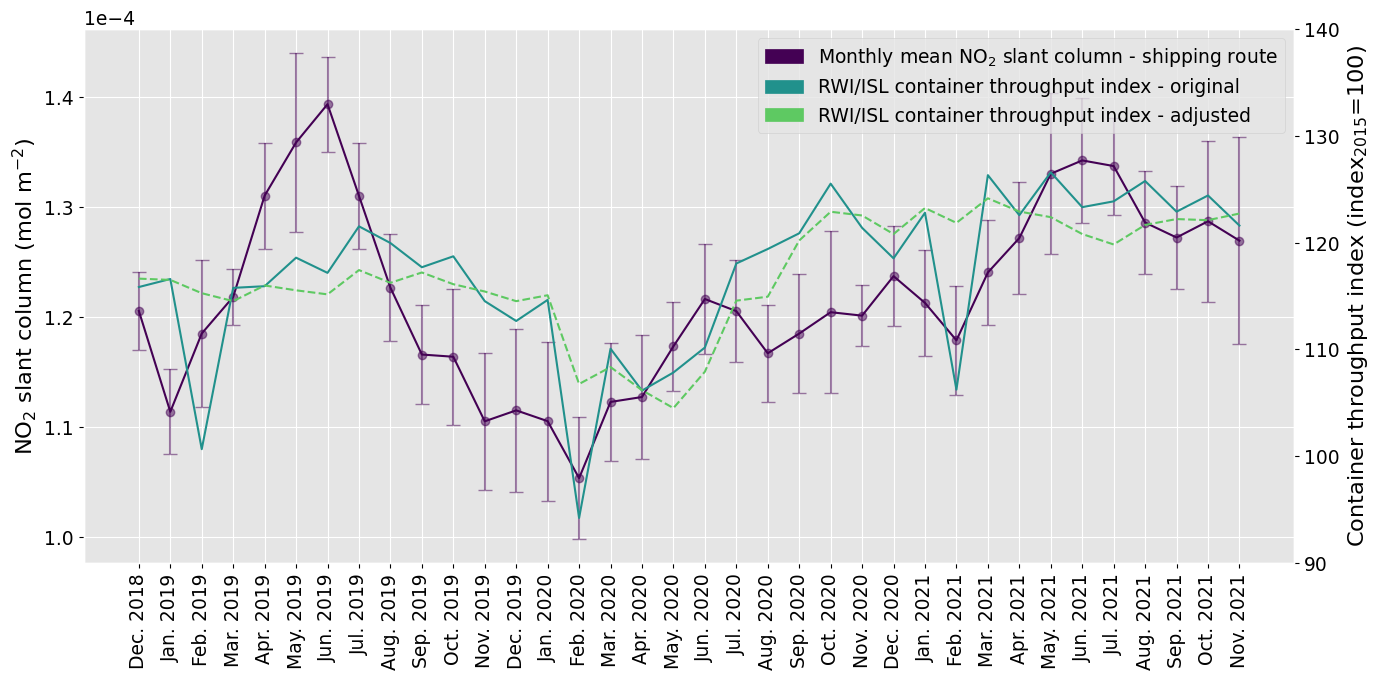

In [196]:
## Prepare data
x = np.array(month_name)
y_ship = [*no2_monthly_mean_shipping.values()]
y_back = [*no2_monthly_mean_background.values()]
yerr_ship = [*no2_monthly_std_shipping.values()]
yerr_back = [*no2_monthly_std_background.values()]
global_throughput_index = pd.read_excel('https://www.isl.org/public/containerumschlag-index/2023-04/containerumschlag-index_230531.xlsx')
start = global_throughput_index.index[global_throughput_index.iloc[:, 0] == datetime.datetime(2018, 12, 1, 0, 0)].item()
end = global_throughput_index.index[global_throughput_index.iloc[:, 0] == datetime.datetime(2021, 11, 1, 0, 0)].item()
global_throughput_original = global_throughput_index.iloc[start:(end + 1), 1].tolist()
global_throughput_adjusted = global_throughput_index.iloc[start:(end + 1), 2].tolist()

## Plot trend time series
fig, ax1 = plt.subplots(figsize=(14, 7))
plt.xticks(rotation = 90)
plt.ylabel("NO$_2$ slant column (mol m$^{-2}$)")
ax2 = ax1.twinx()
ax1.plot(x, y_ship, label='Monthly mean NO$_2$ slant column - shipping route', color='#440154')
ax1.errorbar(x, y_ship, yerr=yerr_ship, fmt='o', capsize=5, alpha=0.5, color='#440154')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
ax2.plot(x, global_throughput_original, label='RWI/ISL container throughput index - original', color='#21918c')
ax2.plot(x, global_throughput_adjusted, linestyle='dashed', label='RWI/ISL container throughput index - adjusted', color='#5ec962')
ax2.grid(False)
ax2.set_ylim([90, 140])
plt.ylabel("Container throughput index (index$_{2015}$=100)")
c1_patch = mpatches.Patch(color='#440154', label='Monthly mean NO$_2$ slant column - shipping route')
c2_patch = mpatches.Patch(color='#21918c', label='RWI/ISL container throughput index - original')
c3_patch = mpatches.Patch(color='#5ec962', label='RWI/ISL container throughput index - adjusted')
plt.legend(handles=[c1_patch, c2_patch, c3_patch], loc='upper right')
plt.tight_layout()
plt.show()

Perform seasonal decomposition on the data

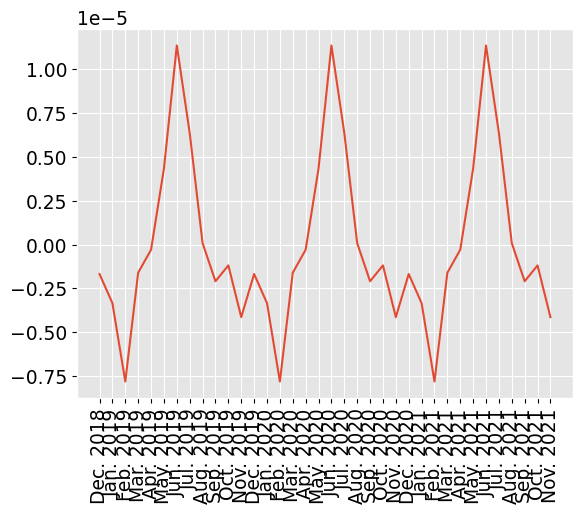

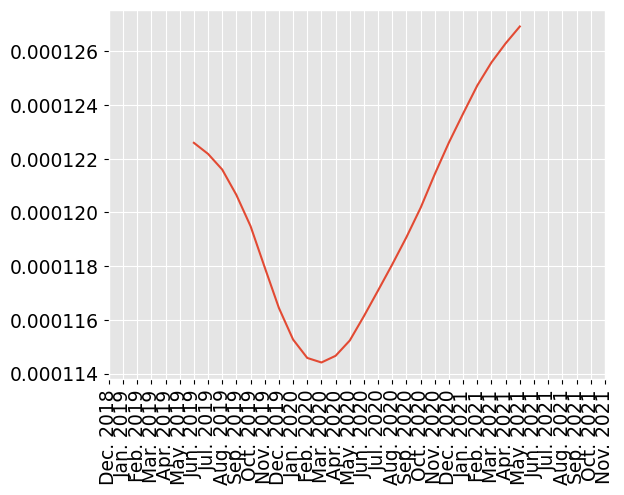

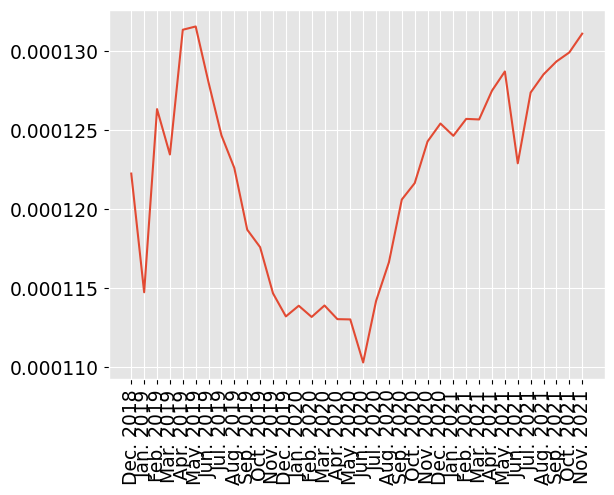

In [197]:
## Perform seasonal decomposition
seasonal_decomp = statsmodels.tsa.seasonal.seasonal_decompose(y_ship, model='additive', period=12)

## Plot seasonality
plt.plot(seasonal_decomp.seasonal)
plt.xticks(np.arange(0, 36), pd.Series(month_name), rotation = 90)
plt.show()

## Plot trend
plt.plot(seasonal_decomp.trend)
plt.xticks(np.arange(0, 36), pd.Series(month_name), rotation = 90)
plt.show()

## Plot deseasonalized NO2 data
plt.plot(y_ship - seasonal_decomp.seasonal)
plt.xticks(np.arange(0, 36), pd.Series(month_name), rotation = 90)
plt.show()

Plot the trend of deseasonalized monthly statistics in shipping route cluster, compared with the global container throughput adjusted index

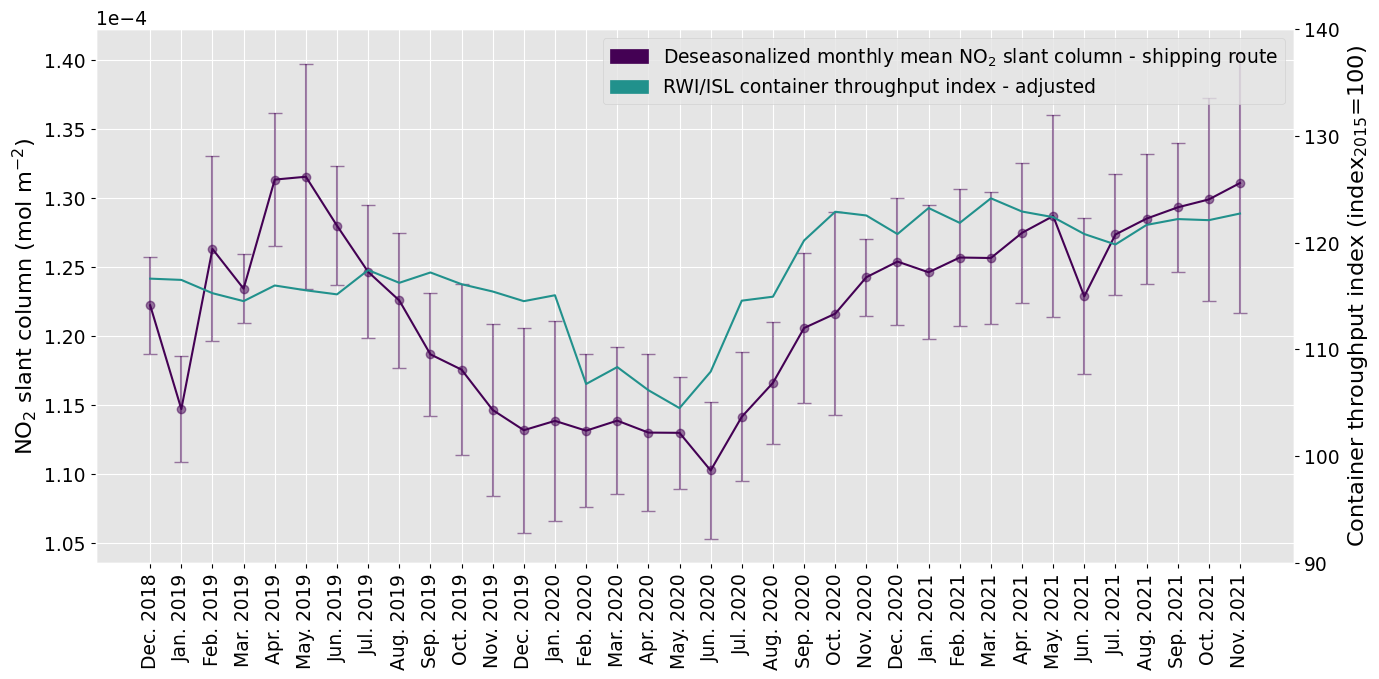

In [198]:
## Prepare data
x = np.array(month_name)
y_ship = [*no2_monthly_mean_shipping.values()]
y_back = [*no2_monthly_mean_background.values()]
yerr_ship = [*no2_monthly_std_shipping.values()]
yerr_back = [*no2_monthly_std_background.values()]
global_throughput_index = pd.read_excel('https://www.isl.org/public/containerumschlag-index/2023-04/containerumschlag-index_230531.xlsx')
start = global_throughput_index.index[global_throughput_index.iloc[:, 0] == datetime.datetime(2018, 12, 1, 0, 0)].item()
end = global_throughput_index.index[global_throughput_index.iloc[:, 0] == datetime.datetime(2021, 11, 1, 0, 0)].item()
global_throughput_adjusted = global_throughput_index.iloc[start:(end + 1), 2].tolist()

## Plot trend time series
fig, ax1 = plt.subplots(figsize=(14, 7))
plt.xticks(rotation = 90)
plt.ylabel("NO$_2$ slant column (mol m$^{-2}$)")
ax2 = ax1.twinx()
ax1.plot(x, y_ship - seasonal_decomp.seasonal, label='Deseasonalized monthly  mean NO$_2$ slant column - shipping route', color='#440154')
ax1.errorbar(x, y_ship - seasonal_decomp.seasonal, yerr=yerr_ship, fmt='o', capsize=5, alpha=0.5, color='#440154')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
ax2.plot(x, global_throughput_adjusted, label='RWI/ISL container throughput index - adjusted', color='#21918c')
ax2.grid(False)
ax2.set_ylim([90, 140])
plt.ylabel("Container throughput index (index$_{2015}$=100)")
c1_patch = mpatches.Patch(color='#440154', label='Deseasonalized monthly mean NO$_2$ slant column - shipping route')
c2_patch = mpatches.Patch(color='#21918c', label='RWI/ISL container throughput index - adjusted')
plt.legend(handles=[c1_patch, c2_patch], loc='upper right')
plt.tight_layout()
plt.show()

Perform statistical analysis

In [199]:
## Monthly mean NO2 on shipping route vs. global throughput index (original)
## Pearson correlation
print('Temporal Pearson correlation between shipping & throughput index (original):', stats.pearsonr(y_ship, global_throughput_original))
print('Temporal Pearson correlation between deseasonalized shipping & throughput index (adjusted):', stats.pearsonr(y_ship - seasonal_decomp.seasonal, global_throughput_adjusted))

# Calculating Kendall Rank correlation
corr, p_value = stats.kendalltau(y_ship, global_throughput_original)
print('Temporal Kendall Rank correlation (original): %.4f' % corr, ', with p-value of %.4f' % p_value)
corr, p_value = stats.kendalltau(y_ship - seasonal_decomp.seasonal, global_throughput_adjusted)
print('Temporal Kendall Rank correlation (deseasonalized & adjusted): %.4f' % corr, ', with p-value of %.4f' % p_value)

# ## Granger-Causality test 
# grangercausalitytests(pd.concat([pd.Series(y_ship), pd.Series(global_throughput_original)], axis=1), maxlag=3)
# testing whether the time series in the second column (global_throughput) Granger causes the time series in the first column (y_ship)

Temporal Pearson correlation between shipping & throughput index (original): PearsonRResult(statistic=0.6002996818833948, pvalue=0.0001086904179039301)
Temporal Pearson correlation between deseasonalized shipping & throughput index (adjusted): PearsonRResult(statistic=0.7102937586410203, pvalue=1.2186709336127595e-06)
Temporal Kendall Rank correlation (original): 0.4381 , with p-value of 0.0002
Temporal Kendall Rank correlation (deseasonalized & adjusted): 0.4952 , with p-value of 0.0000


Calculate yearly mean & std per cluster

1. Shipping route

In [200]:
## Prepare data for shipping-route cluster
data_shipping = np.multiply(copy.deepcopy(no2_scd)[:, :, :], no2_ConvGistar_shipping)
data_shipping_2019 = data_shipping[27:(27 + 365), :, :]
data_shipping_2020 = data_shipping[(27 + 365):(27 + 365 + 366), :, :]
data_shipping_2021 = data_shipping[(27 + 365 + 366):(27 + 365 + 366 + 366), :, :]

## 2019 NO2 column density
print('NO2 mean (2019):', round_sf(np.nanmean(data_shipping_2019), 5), '\nNO2 std (2019):', round_sf(np.nanstd(data_shipping_2019), 4))

## 2020 NO2 column density
print('NO2 mean (2020):', round_sf(np.nanmean(data_shipping_2020), 5), '\nNO2 std (2020):', round_sf(np.nanstd(data_shipping_2020), 4))

## 2021 NO2 column density
print('NO2 mean (2021):', round_sf(np.nanmean(data_shipping_2021), 5), '\nNO2 std (2021):', round_sf(np.nanstd(data_shipping_2021), 4))

NO2 mean (2019): 0.00012255 
NO2 std (2019): 2.22e-05
NO2 mean (2020): 0.00011703 
NO2 std (2020): 1.823e-05
NO2 mean (2021): 0.00012783 
NO2 std (2021): 1.959e-05


In [201]:
## 2020/2019 ratio
ratio_shipping_2020_2019 = np.nanmean(data_shipping_2020, axis=0) / np.nanmean(data_shipping_2019, axis=0)
print('NO2 ratio mean (2020/2019):', round_sf(np.nanmean(ratio_shipping_2020_2019), 4), '\nNO2 ratio std (2020/2019):', round_sf(np.nanstd(ratio_shipping_2020_2019), 4))

## 2021/2020 ratio
ratio_shipping_2021_2020 = np.nanmean(data_shipping_2021, axis=0) / np.nanmean(data_shipping_2020, axis=0)
print('NO2 ratio mean (2021/2020):', round_sf(np.nanmean(ratio_shipping_2021_2020), 4), '\nNO2 ratio std (2021/2020):', round_sf(np.nanstd(ratio_shipping_2021_2020), 4))

## 2020/2019 ratio
ratio_shipping_2021_2019 = np.nanmean(data_shipping_2021, axis=0) / np.nanmean(data_shipping_2019, axis=0)
print('NO2 ratio mean (2021/2019):', round_sf(np.nanmean(ratio_shipping_2021_2019), 4), '\nNO2 ratio std (2021/2019):', round_sf(np.nanstd(ratio_shipping_2021_2019), 4))

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2913848403.py:2: RuntimeWarning: Mean of empty slice
  ratio_shipping_2020_2019 = np.nanmean(data_shipping_2020, axis=0) / np.nanmean(data_shipping_2019, axis=0)


NO2 ratio mean (2020/2019): 0.9546 
NO2 ratio std (2020/2019): 0.007294


C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2913848403.py:6: RuntimeWarning: Mean of empty slice
  ratio_shipping_2021_2020 = np.nanmean(data_shipping_2021, axis=0) / np.nanmean(data_shipping_2020, axis=0)


NO2 ratio mean (2021/2020): 1.092 
NO2 ratio std (2021/2020): 0.009947


C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\2913848403.py:10: RuntimeWarning: Mean of empty slice
  ratio_shipping_2021_2019 = np.nanmean(data_shipping_2021, axis=0) / np.nanmean(data_shipping_2019, axis=0)


NO2 ratio mean (2021/2019): 1.042 
NO2 ratio std (2021/2019): 0.00971


Calculate yearly mean & std per cluster

2. Background

In [202]:
## Prepare data for background cluster
data_background = np.multiply(copy.deepcopy(no2_scd)[:, :, :], no2_ConvGistar_background)
data_background_2019 = data_background[27:(27 + 365), :, :]
data_background_2020 = data_background[(27 + 365):(27 + 365 + 366), :, :]
data_background_2021 = data_background[(27 + 365 + 366):(27 + 365 + 366 + 366), :, :]

## 2019 NO2 column density
print('NO2 mean (2019):', round_sf(np.nanmean(data_background_2019), 5), '\nNO2 std (2019):', round_sf(np.nanstd(data_background_2019), 4))

## 2020 NO2 column density
print('NO2 mean (2020):', round_sf(np.nanmean(data_background_2020), 5), '\nNO2 std (2020):', round_sf(np.nanstd(data_background_2020), 4))

## 2021 NO2 column density
print('NO2 mean (2021):', round_sf(np.nanmean(data_background_2021), 5), '\nNO2 std (2021):', round_sf(np.nanstd(data_background_2021), 4))

NO2 mean (2019): 0.000115 
NO2 std (2019): 1.968e-05
NO2 mean (2020): 0.00011018 
NO2 std (2020): 1.662e-05
NO2 mean (2021): 0.00012118 
NO2 std (2021): 1.839e-05


In [203]:
## 2020/2019 ratio
ratio_background_2020_2019 = np.nanmean(data_background_2020, axis=0) / np.nanmean(data_background_2019, axis=0)
print('NO2 ratio mean (2020/2019):', round_sf(np.nanmean(ratio_background_2020_2019), 4), '\nNO2 ratio std (2020/2019):', round_sf(np.nanstd(ratio_background_2020_2019), 4))

## 2021/2020 ratio
ratio_background_2021_2020 = np.nanmean(data_background_2021, axis=0) / np.nanmean(data_background_2020, axis=0)
print('NO2 ratio mean (2021/2020):', round_sf(np.nanmean(ratio_background_2021_2020), 4), '\nNO2 ratio std (2021/2020):', round_sf(np.nanstd(ratio_background_2021_2020), 4))

## 2020/2019 ratio
ratio_background_2021_2019 = np.nanmean(data_background_2021, axis=0) / np.nanmean(data_background_2019, axis=0)
print('NO2 ratio mean (2021/2019):', round_sf(np.nanmean(ratio_background_2021_2019), 4), '\nNO2 ratio std (2021/2019):', round_sf(np.nanstd(ratio_background_2021_2019), 4))

C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\826720511.py:2: RuntimeWarning: Mean of empty slice
  ratio_background_2020_2019 = np.nanmean(data_background_2020, axis=0) / np.nanmean(data_background_2019, axis=0)


NO2 ratio mean (2020/2019): 0.9574 
NO2 ratio std (2020/2019): 0.007298


C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\826720511.py:6: RuntimeWarning: Mean of empty slice
  ratio_background_2021_2020 = np.nanmean(data_background_2021, axis=0) / np.nanmean(data_background_2020, axis=0)


NO2 ratio mean (2021/2020): 1.099 
NO2 ratio std (2021/2020): 0.008155


C:\Users\kimsa\AppData\Local\Temp\ipykernel_8120\826720511.py:10: RuntimeWarning: Mean of empty slice
  ratio_background_2021_2019 = np.nanmean(data_background_2021, axis=0) / np.nanmean(data_background_2019, axis=0)


NO2 ratio mean (2021/2019): 1.052 
NO2 ratio std (2021/2019): 0.007575
